# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

## Global COVID-19 Analysis

In [8]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/30/20


3/30/20
Country/Region             
US                   161807
Italy                101739
Spain                 87956
China                 82198
Germany               66885
...                     ...
Brunei                  127
Sri Lanka               122
West Bank and Gaza      116
Cambodia                107
Georgia                 103

[106 rows x 1 columns]

## Curve Fitting Global COVID-19 Cases

In [9]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 161807
	Confirmed cases on 3/23/20 	 43847
	Ratio: 3.69
	Weekly increase: 269.0 %
	Daily increase: 20.5 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Exponential Fit **

	R^2: 0.9933223791938807
	Doubling Time (represents overall growth):  3.44 (± 0.14 ) days


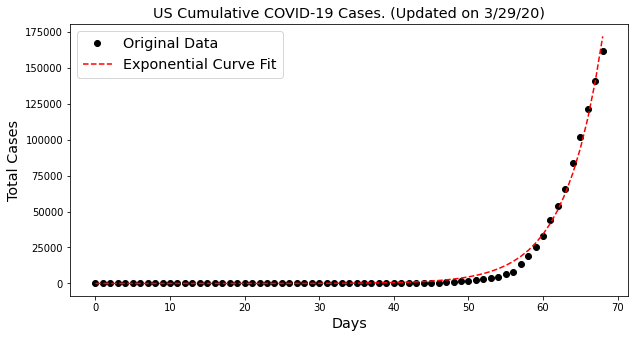



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 101739
	Confirmed cases on 3/23/20 	 63927
	Ratio: 1.59
	Weekly increase: 59.1 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.4 days

** Based on Logistic Fit**

	R^2: 0.9996347326361673
	Doubling Time (during middle of growth):  7.56 (± 0.19 ) days

** Based on Exponential Fit **

	R^2: 0.9699763335158614
	Doubling Time (represents overall growth):  5.76 (± 0.57 ) days


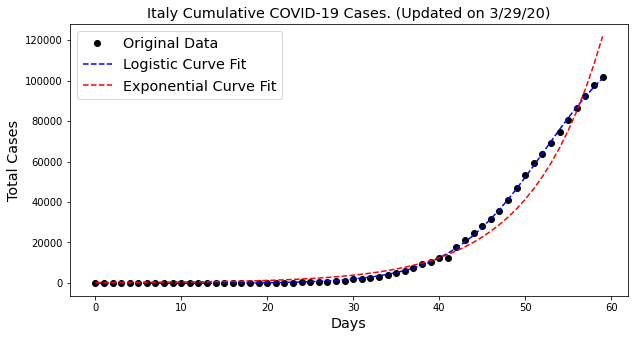



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 87956
	Confirmed cases on 3/23/20 	 35136
	Ratio: 2.5
	Weekly increase: 150.3 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.999324017877559
	Doubling Time (during middle of growth):  6.05 (± 0.22 ) days

** Based on Exponential Fit **

	R^2: 0.9913203288430683
	Doubling Time (represents overall growth):  4.61 (± 0.24 ) days


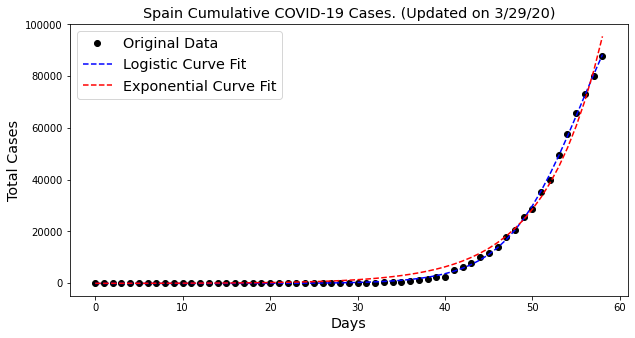



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 82198
	Confirmed cases on 3/23/20 	 81498
	Ratio: 1.01
	Weekly increase: 0.9 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 567.3 days

** Based on Logistic Fit**

	R^2: 0.995743312022023
	Doubling Time (during middle of growth):  6.52 (± 0.48 ) days


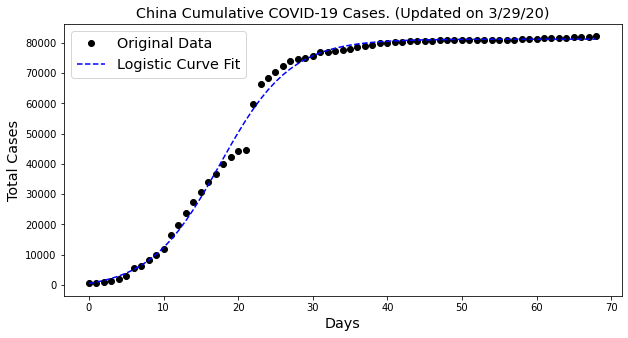



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 66885
	Confirmed cases on 3/23/20 	 29056
	Ratio: 2.3
	Weekly increase: 130.2 %
	Daily increase: 12.6 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9987056726874645
	Doubling Time (during middle of growth):  6.24 (± 0.3 ) days

** Based on Exponential Fit **

	R^2: 0.9898783932483951
	Doubling Time (represents overall growth):  4.84 (± 0.26 ) days


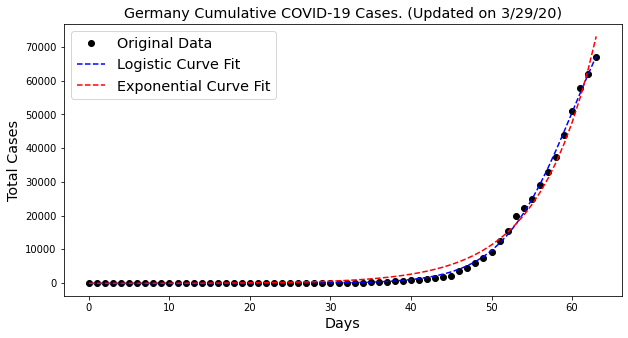



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 45170
	Confirmed cases on 3/23/20 	 20123
	Ratio: 2.24
	Weekly increase: 124.5 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9994154808389414
	Doubling Time (during middle of growth):  7.11 (± 0.23 ) days

** Based on Exponential Fit **

	R^2: 0.9940173868044065
	Doubling Time (represents overall growth):  5.07 (± 0.2 ) days


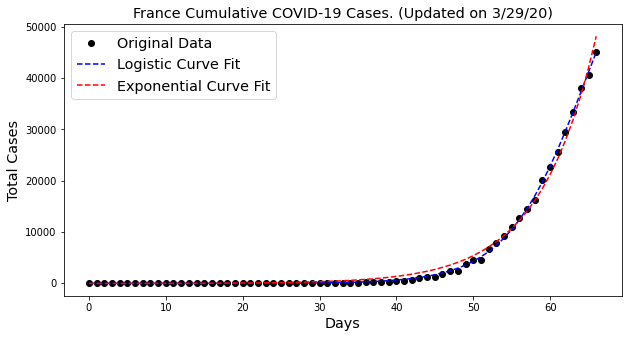



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 41495
	Confirmed cases on 3/23/20 	 23049
	Ratio: 1.8
	Weekly increase: 80.0 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9948633453298797
	Doubling Time (during middle of growth):  22.04 (± 8.85 ) days


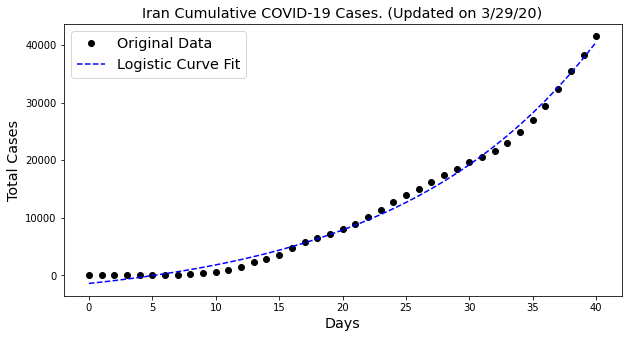



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 22453
	Confirmed cases on 3/23/20 	 6726
	Ratio: 3.34
	Weekly increase: 233.8 %
	Daily increase: 18.8 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.9971775429698155
	Doubling Time (represents overall growth):  3.94 (± 0.11 ) days


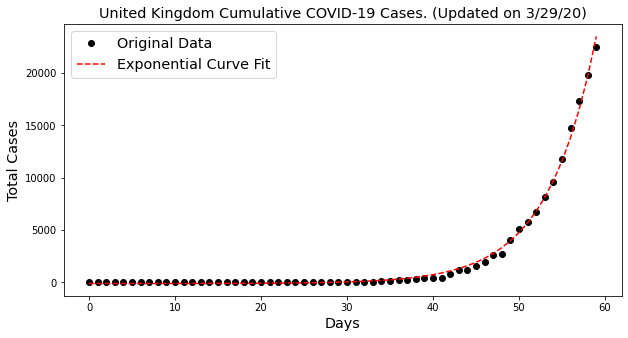



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 15922
	Confirmed cases on 3/23/20 	 8795
	Ratio: 1.81
	Weekly increase: 81.0 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9989644128229352
	Doubling Time (during middle of growth):  5.35 (± 0.31 ) days

** Based on Exponential Fit **

	R^2: 0.9553130166772273
	Doubling Time (represents overall growth):  4.5 (± 0.79 ) days


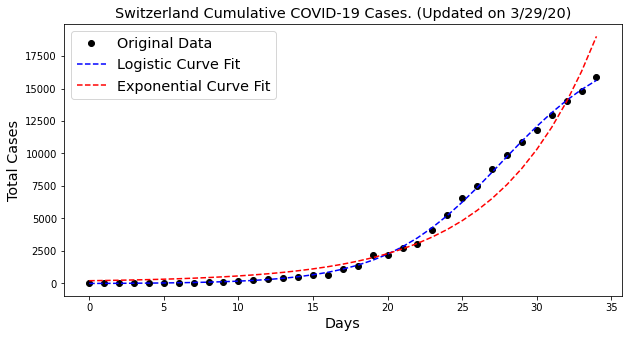



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 11899
	Confirmed cases on 3/23/20 	 3743
	Ratio: 3.18
	Weekly increase: 217.9 %
	Daily increase: 18.0 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Exponential Fit **

	R^2: 0.9978219908636984
	Doubling Time (represents overall growth):  4.06 (± 0.11 ) days


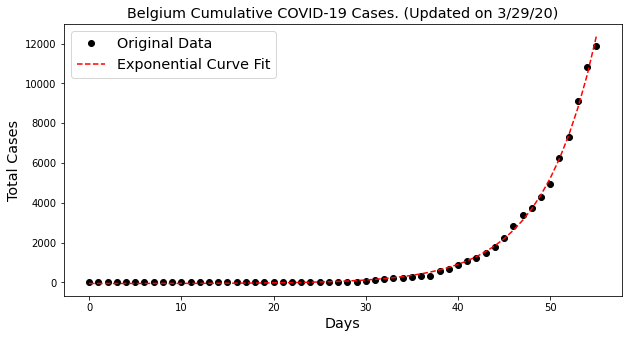



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 11817
	Confirmed cases on 3/23/20 	 4764
	Ratio: 2.48
	Weekly increase: 148.0 %
	Daily increase: 13.9 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9996304477761525
	Doubling Time (during middle of growth):  7.06 (± 0.32 ) days

** Based on Exponential Fit **

	R^2: 0.9924071145437281
	Doubling Time (represents overall growth):  4.56 (± 0.34 ) days


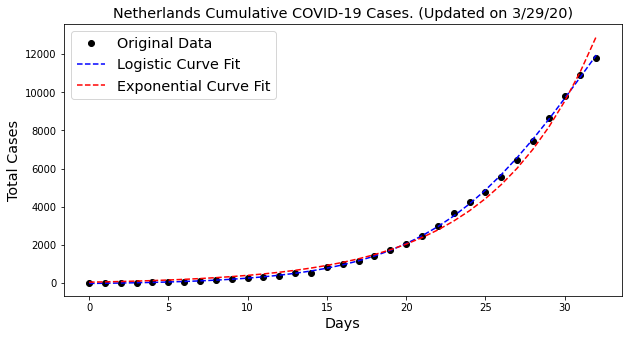



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 10827
	Confirmed cases on 3/23/20 	 1529
	Ratio: 7.08
	Weekly increase: 608.1 %
	Daily increase: 32.3 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.9972443009689245
	Doubling Time (during middle of growth):  3.09 (± 0.44 ) days

** Based on Exponential Fit **

	R^2: 0.9887839022580438
	Doubling Time (represents overall growth):  2.54 (± 0.31 ) days


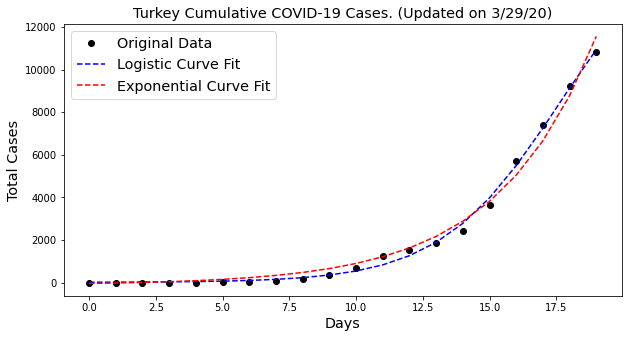



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 9661
	Confirmed cases on 3/23/20 	 8961
	Ratio: 1.08
	Weekly increase: 7.8 %
	Daily increase: 1.1 % per day
	Doubling Time (represents recent growth): 64.5 days

** Based on Logistic Fit**

	R^2: 0.9957107353183288
	Doubling Time (during middle of growth):  5.12 (± 0.4 ) days


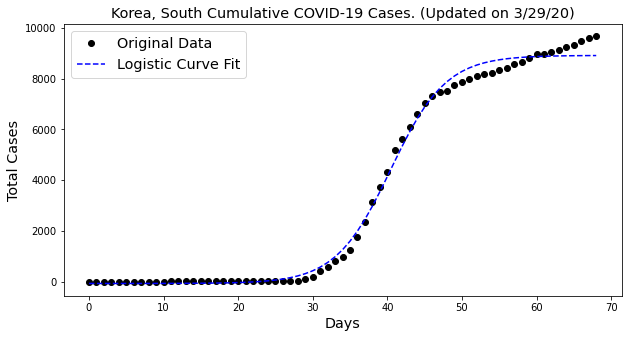



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 9618
	Confirmed cases on 3/23/20 	 4474
	Ratio: 2.15
	Weekly increase: 115.0 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9989660212053133
	Doubling Time (during middle of growth):  5.32 (± 0.32 ) days

** Based on Exponential Fit **

	R^2: 0.9824177750315564
	Doubling Time (represents overall growth):  4.95 (± 0.57 ) days


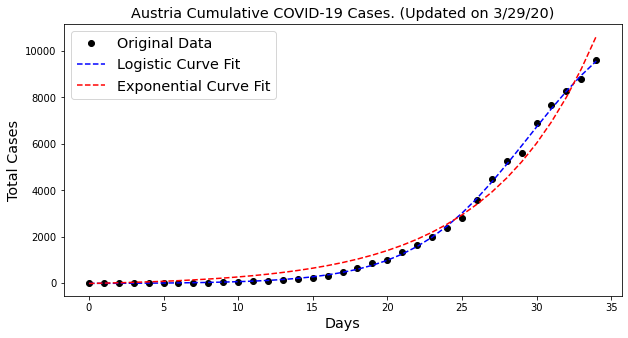



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 7398
	Confirmed cases on 3/23/20 	 2088
	Ratio: 3.54
	Weekly increase: 254.3 %
	Daily increase: 19.8 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.9942926246371053
	Doubling Time (represents overall growth):  3.72 (± 0.14 ) days


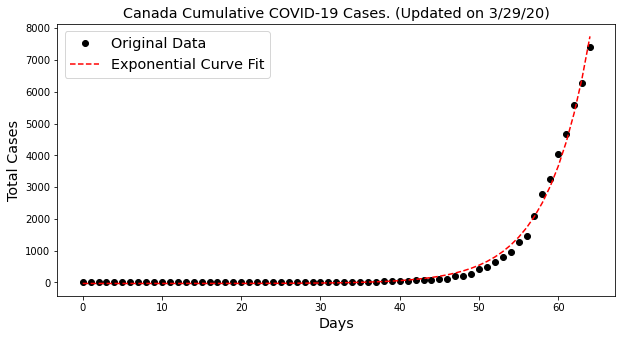



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 6408
	Confirmed cases on 3/23/20 	 2060
	Ratio: 3.11
	Weekly increase: 211.1 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.9989505517779509
	Doubling Time (during middle of growth):  5.07 (± 0.37 ) days

** Based on Exponential Fit **

	R^2: 0.992331700228108
	Doubling Time (represents overall growth):  3.93 (± 0.32 ) days


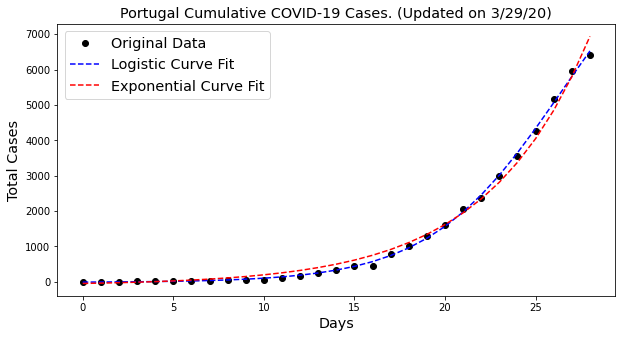



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 4695
	Confirmed cases on 3/23/20 	 1071
	Ratio: 4.38
	Weekly increase: 338.4 %
	Daily increase: 23.5 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.9946922445449184
	Doubling Time (during middle of growth):  3.97 (± 0.5 ) days

** Based on Exponential Fit **

	R^2: 0.9852691553500224
	Doubling Time (represents overall growth):  3.59 (± 0.31 ) days


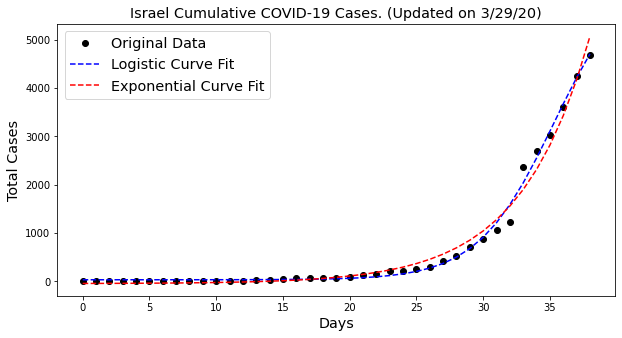



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 4579
	Confirmed cases on 3/23/20 	 1924
	Ratio: 2.38
	Weekly increase: 138.0 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9986059132271339
	Doubling Time (during middle of growth):  4.32 (± 0.29 ) days

** Based on Exponential Fit **

	R^2: 0.9803494817813634
	Doubling Time (represents overall growth):  4.45 (± 0.53 ) days


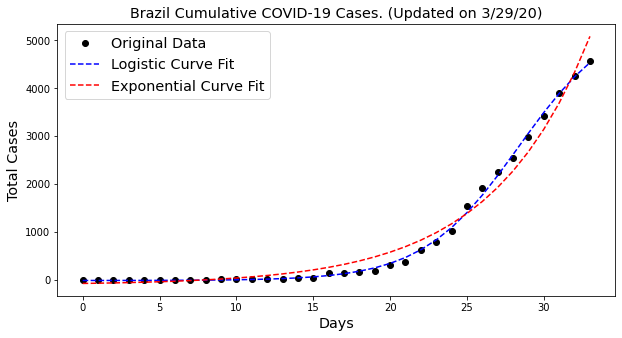



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 4445
	Confirmed cases on 3/23/20 	 2621
	Ratio: 1.7
	Weekly increase: 69.6 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9960590322736711
	Doubling Time (during middle of growth):  10.58 (± 1.96 ) days

** Based on Exponential Fit **

	R^2: 0.963505334042394
	Doubling Time (represents overall growth):  5.83 (± 1.07 ) days


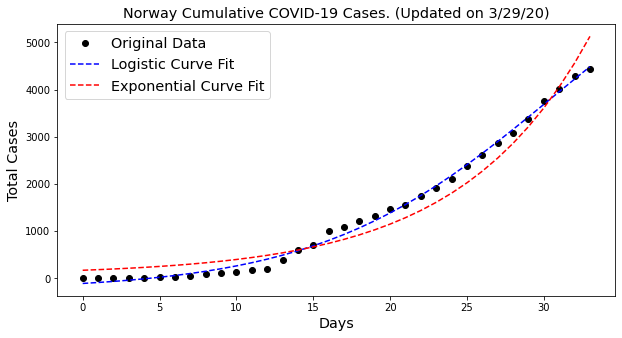



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 4361
	Confirmed cases on 3/23/20 	 1682
	Ratio: 2.59
	Weekly increase: 159.3 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Exponential Fit **

	R^2: 0.9902241908387578
	Doubling Time (represents overall growth):  4.48 (± 0.23 ) days


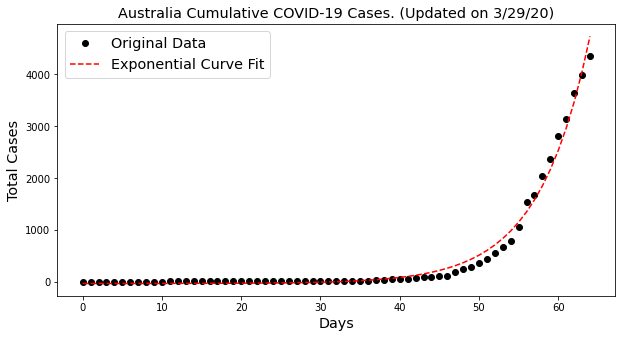



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 4028
	Confirmed cases on 3/23/20 	 2046
	Ratio: 1.97
	Weekly increase: 96.9 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9948555713639965
	Doubling Time (during middle of growth):  9.87 (± 1.08 ) days

** Based on Exponential Fit **

	R^2: 0.9911024425792354
	Doubling Time (represents overall growth):  7.03 (± 0.39 ) days


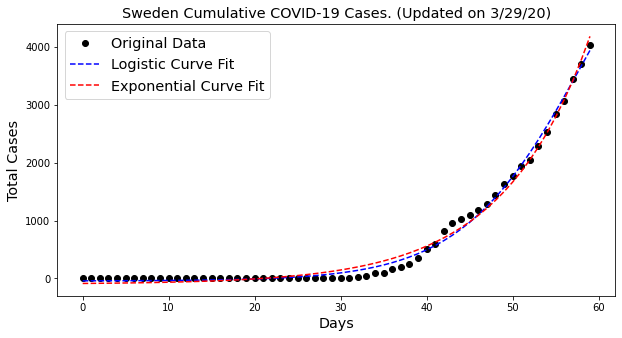



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 3001
	Confirmed cases on 3/23/20 	 1236
	Ratio: 2.43
	Weekly increase: 142.8 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9973550512731184
	Doubling Time (during middle of growth):  6.52 (± 0.81 ) days

** Based on Exponential Fit **

	R^2: 0.991082606632624
	Doubling Time (represents overall growth):  5.12 (± 0.49 ) days


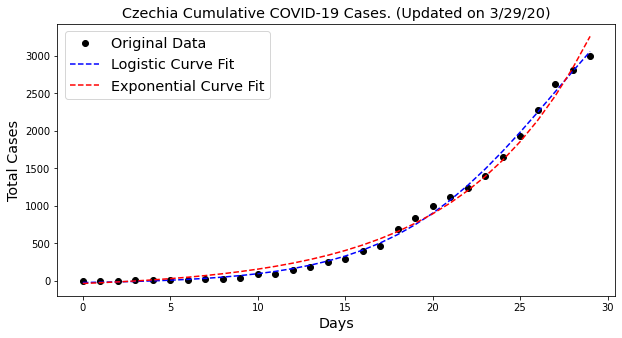



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 2910
	Confirmed cases on 3/23/20 	 1125
	Ratio: 2.59
	Weekly increase: 158.7 %
	Daily increase: 14.5 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9983860572278204
	Doubling Time (during middle of growth):  5.35 (± 0.45 ) days

** Based on Exponential Fit **

	R^2: 0.9893152850501039
	Doubling Time (represents overall growth):  4.74 (± 0.46 ) days


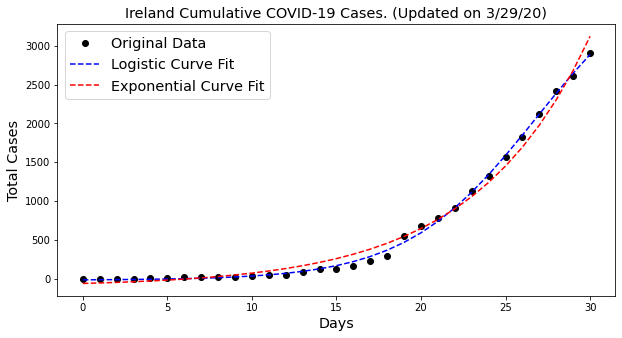



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 2755
	Confirmed cases on 3/23/20 	 1572
	Ratio: 1.75
	Weekly increase: 75.3 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9856720386935615
	Doubling Time (during middle of growth):  13.44 (± 6.69 ) days


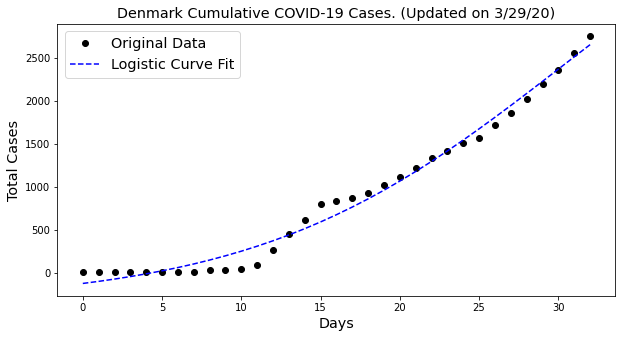



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 2626
	Confirmed cases on 3/23/20 	 1518
	Ratio: 1.73
	Weekly increase: 73.0 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9982305880104941
	Doubling Time (during middle of growth):  6.17 (± 0.32 ) days

** Based on Exponential Fit **

	R^2: 0.9816679746226995
	Doubling Time (represents overall growth):  6.21 (± 0.45 ) days


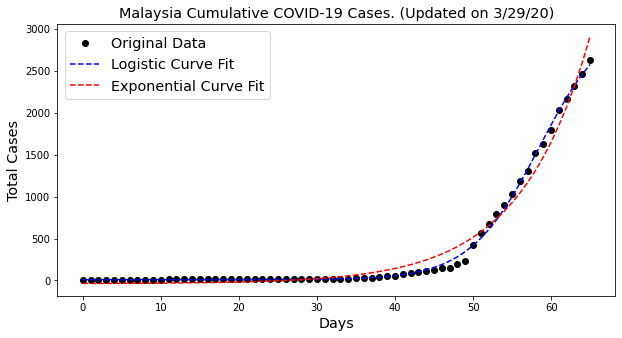



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 2449
	Confirmed cases on 3/23/20 	 746
	Ratio: 3.28
	Weekly increase: 228.3 %
	Daily increase: 18.5 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.99881354993854
	Doubling Time (during middle of growth):  5.66 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.9953556431203966
	Doubling Time (represents overall growth):  4.26 (± 0.28 ) days


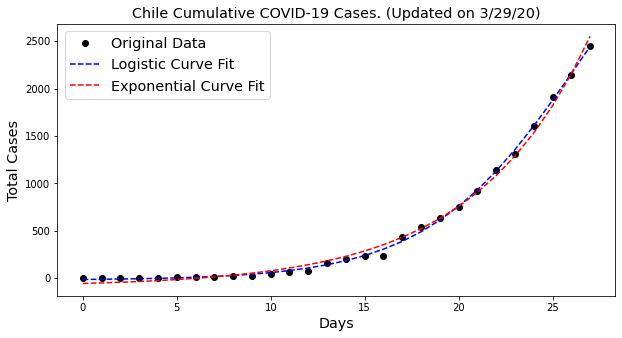



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 2109
	Confirmed cases on 3/23/20 	 576
	Ratio: 3.66
	Weekly increase: 266.1 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9980328893535587
	Doubling Time (during middle of growth):  6.82 (± 0.74 ) days

** Based on Exponential Fit **

	R^2: 0.9976960832186309
	Doubling Time (represents overall growth):  3.87 (± 0.15 ) days


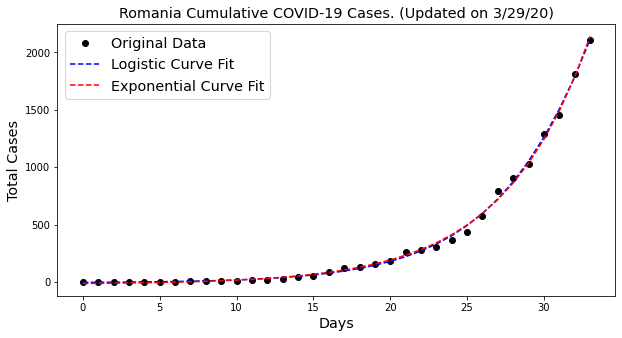



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 2055
	Confirmed cases on 3/23/20 	 749
	Ratio: 2.74
	Weekly increase: 174.4 %
	Daily increase: 15.5 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.999529843918353
	Doubling Time (during middle of growth):  6.54 (± 0.4 ) days

** Based on Exponential Fit **

	R^2: 0.9967680779250273
	Doubling Time (represents overall growth):  4.9 (± 0.3 ) days


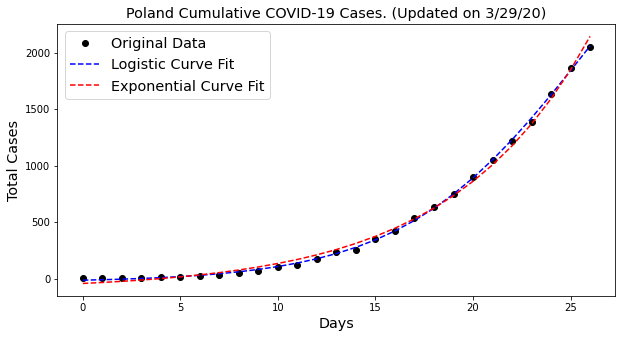



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1988
	Confirmed cases on 3/23/20 	 875
	Ratio: 2.27
	Weekly increase: 127.2 %
	Daily increase: 12.4 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9978332408609171
	Doubling Time (during middle of growth):  4.08 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.9704561842438856
	Doubling Time (represents overall growth):  5.08 (± 0.86 ) days


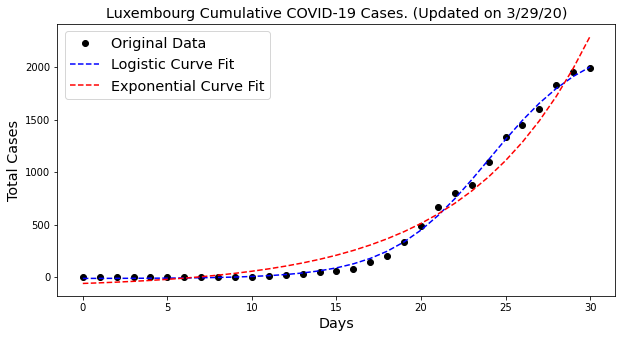



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1962
	Confirmed cases on 3/23/20 	 981
	Ratio: 2.0
	Weekly increase: 100.0 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9947832432998864
	Doubling Time (during middle of growth):  3.53 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.9610617500262871
	Doubling Time (represents overall growth):  4.82 (± 0.94 ) days


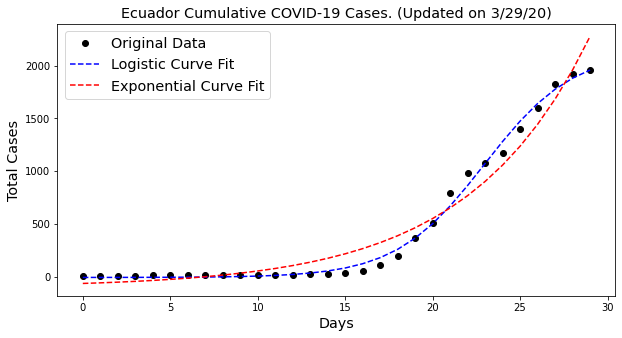



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1866
	Confirmed cases on 3/23/20 	 1128
	Ratio: 1.65
	Weekly increase: 65.4 %
	Daily increase: 7.5 % per day
	Doubling Time (represents recent growth): 9.6 days

** Based on Logistic Fit**

	R^2: 0.9930695892511158
	Doubling Time (during middle of growth):  22.43 (± 4.35 ) days

** Based on Exponential Fit **

	R^2: 0.9930411276078082
	Doubling Time (represents overall growth):  11.78 (± 0.62 ) days


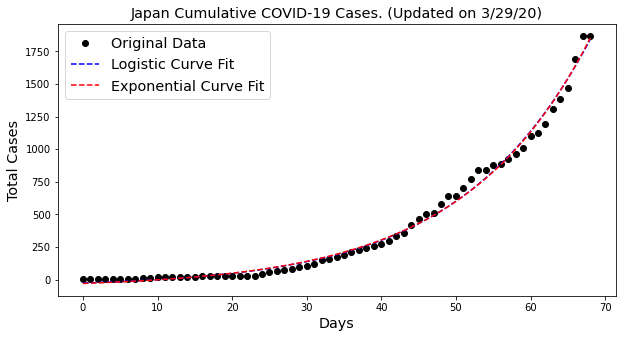



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1836
	Confirmed cases on 3/23/20 	 438
	Ratio: 4.19
	Weekly increase: 319.2 %
	Daily increase: 22.7 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.999068688276498
	Doubling Time (represents overall growth):  3.37 (± 0.05 ) days


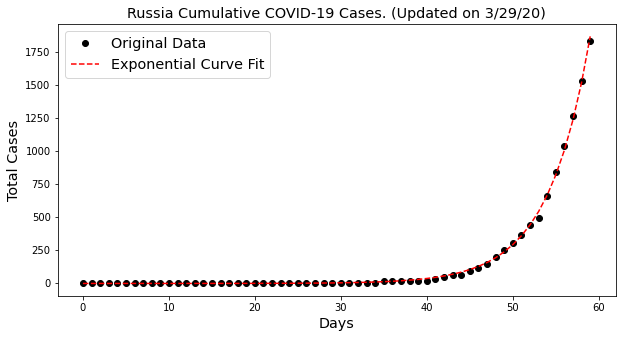



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1717
	Confirmed cases on 3/23/20 	 875
	Ratio: 1.96
	Weekly increase: 96.2 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9943924036078083
	Doubling Time (during middle of growth):  4.97 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.9742071819405901
	Doubling Time (represents overall growth):  5.74 (± 0.86 ) days


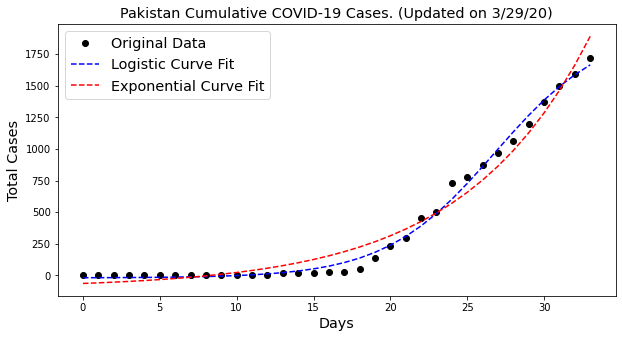



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1546
	Confirmed cases on 3/23/20 	 462
	Ratio: 3.35
	Weekly increase: 234.6 %
	Daily increase: 18.8 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.994699738950536
	Doubling Time (represents overall growth):  3.81 (± 0.15 ) days


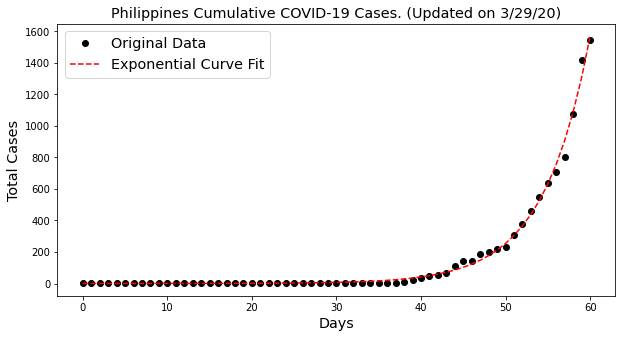



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1524
	Confirmed cases on 3/23/20 	 721
	Ratio: 2.11
	Weekly increase: 111.4 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Exponential Fit **

	R^2: 0.9815513722540722
	Doubling Time (represents overall growth):  4.73 (± 0.32 ) days


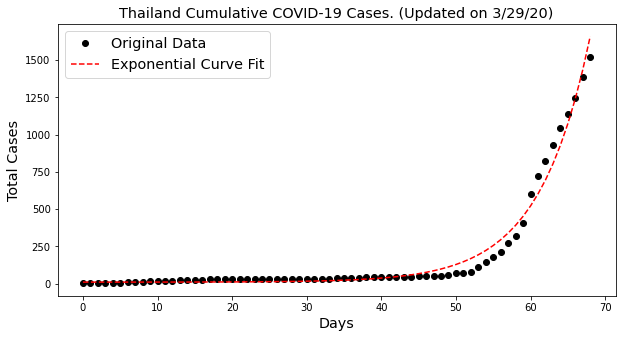



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1453
	Confirmed cases on 3/23/20 	 562
	Ratio: 2.59
	Weekly increase: 158.5 %
	Daily increase: 14.5 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9978242738217894
	Doubling Time (during middle of growth):  4.94 (± 0.48 ) days

** Based on Exponential Fit **

	R^2: 0.9854627222626127
	Doubling Time (represents overall growth):  5.51 (± 0.71 ) days


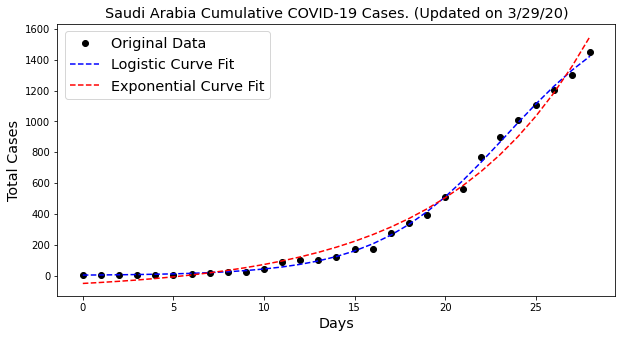



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1414
	Confirmed cases on 3/23/20 	 579
	Ratio: 2.44
	Weekly increase: 144.2 %
	Daily increase: 13.6 % per day
	Doubling Time (represents recent growth): 5.4 days

** Based on Logistic Fit**

	R^2: 0.9990683207455232
	Doubling Time (during middle of growth):  6.61 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.9945156403288081
	Doubling Time (represents overall growth):  5.63 (± 0.45 ) days


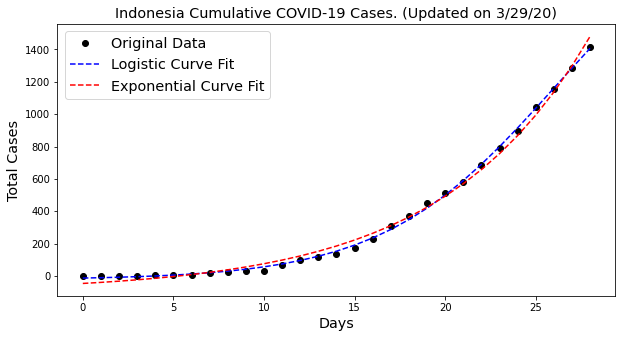



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1352
	Confirmed cases on 3/23/20 	 700
	Ratio: 1.93
	Weekly increase: 93.1 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9973842169205267
	Doubling Time (during middle of growth):  7.05 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.987614918351021
	Doubling Time (represents overall growth):  6.0 (± 0.37 ) days


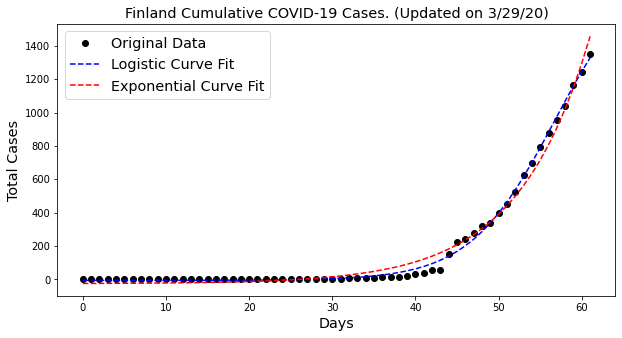



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1326
	Confirmed cases on 3/23/20 	 402
	Ratio: 3.3
	Weekly increase: 229.9 %
	Daily increase: 18.6 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9950442620368554
	Doubling Time (during middle of growth):  3.0 (± 0.42 ) days

** Based on Exponential Fit **

	R^2: 0.966412031093335
	Doubling Time (represents overall growth):  4.55 (± 0.92 ) days


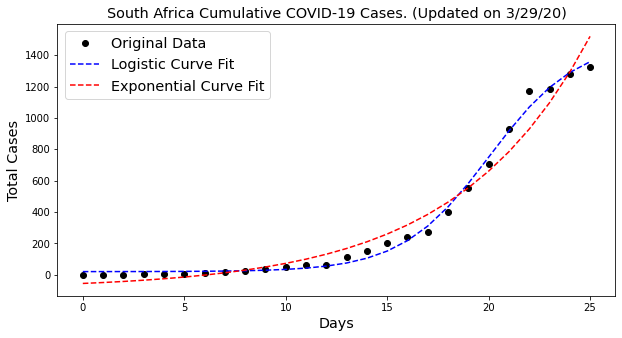



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1251
	Confirmed cases on 3/23/20 	 499
	Ratio: 2.51
	Weekly increase: 150.7 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Exponential Fit **

	R^2: 0.9936789647445896
	Doubling Time (represents overall growth):  4.62 (± 0.2 ) days


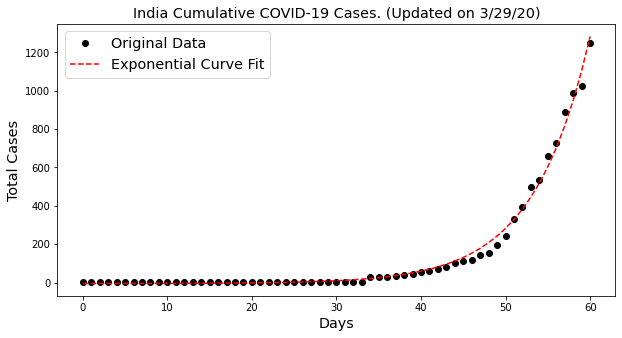



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1212
	Confirmed cases on 3/23/20 	 695
	Ratio: 1.74
	Weekly increase: 74.4 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days

** Based on Logistic Fit**

	R^2: 0.9958323900514745
	Doubling Time (during middle of growth):  9.67 (± 1.69 ) days

** Based on Exponential Fit **

	R^2: 0.9914439521299451
	Doubling Time (represents overall growth):  7.87 (± 0.81 ) days


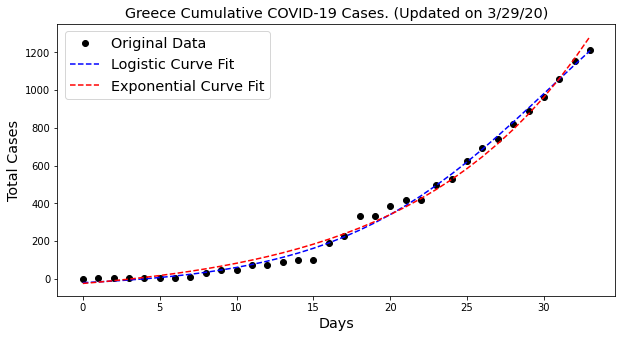



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 1086
	Confirmed cases on 3/23/20 	 588
	Ratio: 1.85
	Weekly increase: 84.7 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.998110685400947
	Doubling Time (during middle of growth):  6.73 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.9896857486774332
	Doubling Time (represents overall growth):  7.36 (± 0.85 ) days


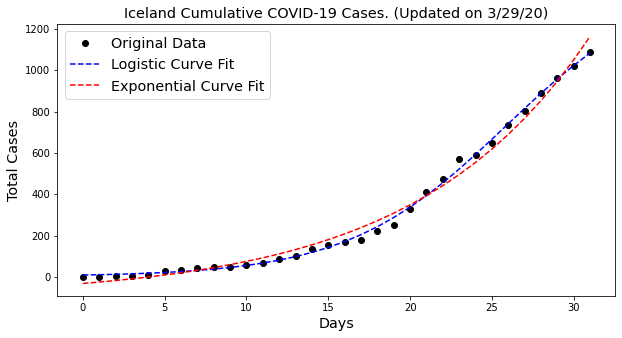



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 993
	Confirmed cases on 3/23/20 	 316
	Ratio: 3.14
	Weekly increase: 214.2 %
	Daily increase: 17.8 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.9978251587750115
	Doubling Time (during middle of growth):  6.7 (± 0.79 ) days

** Based on Exponential Fit **

	R^2: 0.9971955420548198
	Doubling Time (represents overall growth):  3.95 (± 0.18 ) days


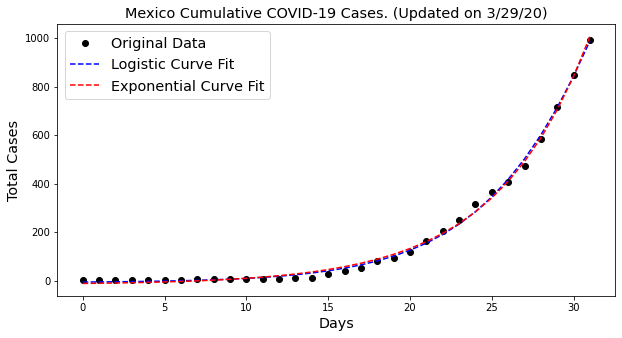



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 989
	Confirmed cases on 3/23/20 	 345
	Ratio: 2.87
	Weekly increase: 186.7 %
	Daily increase: 16.2 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9957825035274103
	Doubling Time (during middle of growth):  5.51 (± 1.22 ) days

** Based on Exponential Fit **

	R^2: 0.9924763888677753
	Doubling Time (represents overall growth):  4.69 (± 0.58 ) days


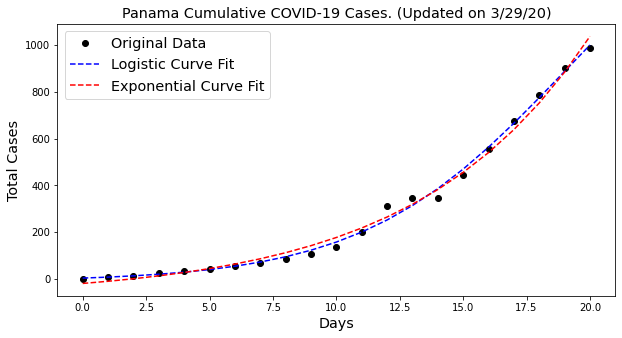



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 950
	Confirmed cases on 3/23/20 	 395
	Ratio: 2.41
	Weekly increase: 140.5 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9913659743604002
	Doubling Time (during middle of growth):  9.38 (± 4.04 ) days

** Based on Exponential Fit **

	R^2: 0.990918087864131
	Doubling Time (represents overall growth):  6.04 (± 0.78 ) days


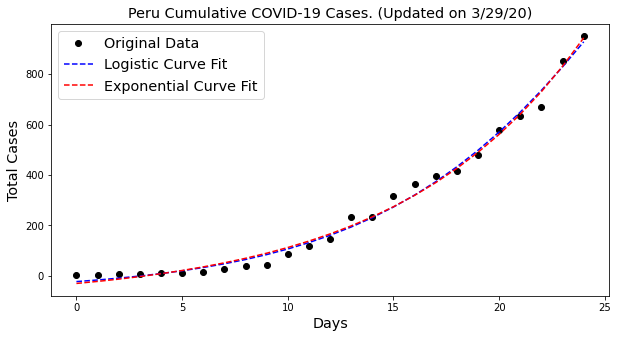



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 901
	Confirmed cases on 3/23/20 	 245
	Ratio: 3.68
	Weekly increase: 267.8 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9974123302345158
	Doubling Time (during middle of growth):  3.77 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.9839691238423827
	Doubling Time (represents overall growth):  3.6 (± 0.4 ) days


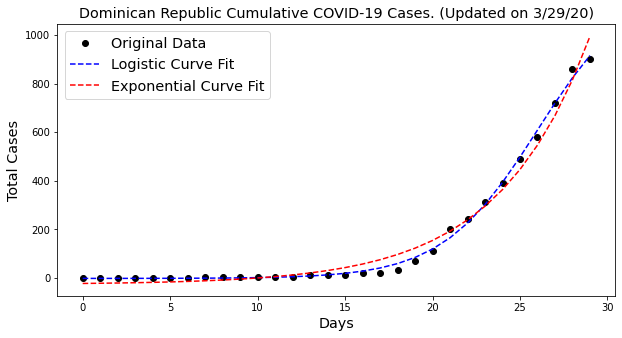



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 879
	Confirmed cases on 3/23/20 	 509
	Ratio: 1.73
	Weekly increase: 72.7 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.9910429786448365
	Doubling Time (during middle of growth):  15.14 (± 2.51 ) days

** Based on Exponential Fit **

	R^2: 0.9910429791585001
	Doubling Time (represents overall growth):  7.57 (± 0.39 ) days


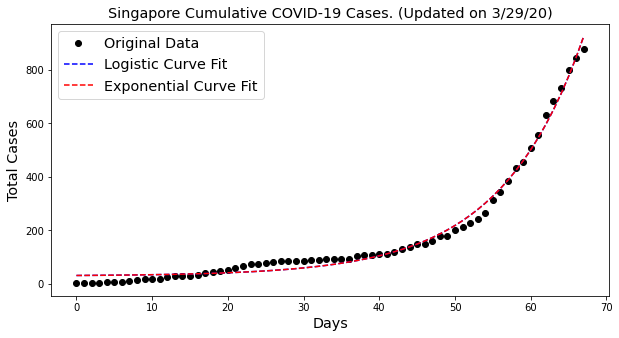



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 820
	Confirmed cases on 3/23/20 	 301
	Ratio: 2.72
	Weekly increase: 172.4 %
	Daily increase: 15.4 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9966621025127642
	Doubling Time (during middle of growth):  4.76 (± 0.6 ) days

** Based on Exponential Fit **

	R^2: 0.9872716961186052
	Doubling Time (represents overall growth):  4.61 (± 0.53 ) days


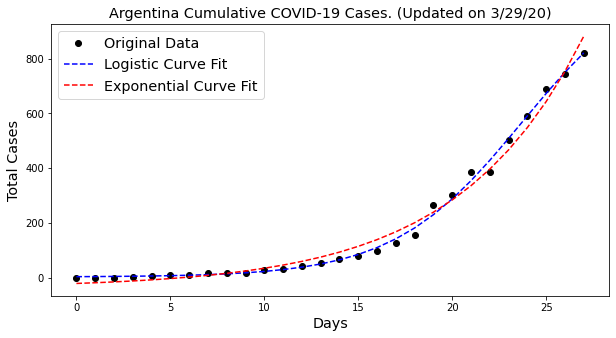



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 798
	Confirmed cases on 3/23/20 	 277
	Ratio: 2.88
	Weekly increase: 188.1 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9956899812679165
	Doubling Time (during middle of growth):  5.12 (± 0.84 ) days

** Based on Exponential Fit **

	R^2: 0.9880472117403115
	Doubling Time (represents overall growth):  5.18 (± 0.7 ) days


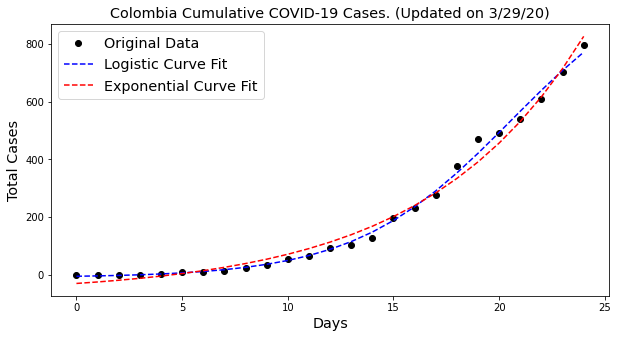



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 790
	Confirmed cases on 3/23/20 	 315
	Ratio: 2.51
	Weekly increase: 150.8 %
	Daily increase: 14.0 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9987641201418687
	Doubling Time (during middle of growth):  4.61 (± 0.29 ) days

** Based on Exponential Fit **

	R^2: 0.9855154647410628
	Doubling Time (represents overall growth):  4.65 (± 0.46 ) days


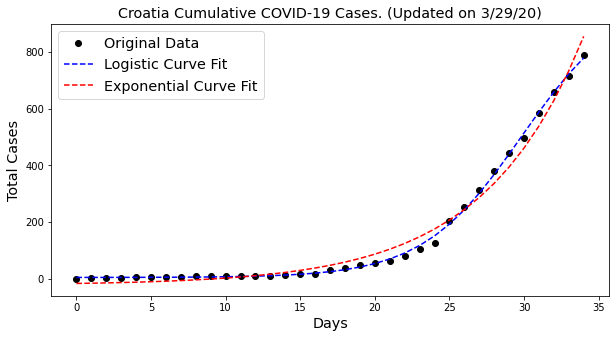



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 785
	Confirmed cases on 3/23/20 	 249
	Ratio: 3.15
	Weekly increase: 215.3 %
	Daily increase: 17.8 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.9914588054287241
	Doubling Time (during middle of growth):  6.64 (± 2.03 ) days

** Based on Exponential Fit **

	R^2: 0.9905294726767946
	Doubling Time (represents overall growth):  4.28 (± 0.46 ) days


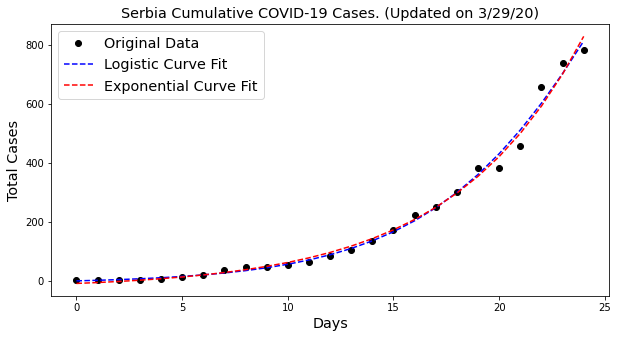



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 756
	Confirmed cases on 3/23/20 	 442
	Ratio: 1.71
	Weekly increase: 71.0 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9931489088599532
	Doubling Time (during middle of growth):  20.59 (± 24.07 ) days

** Based on Exponential Fit **

	R^2: 0.9745712495720782
	Doubling Time (represents overall growth):  7.9 (± 2.02 ) days


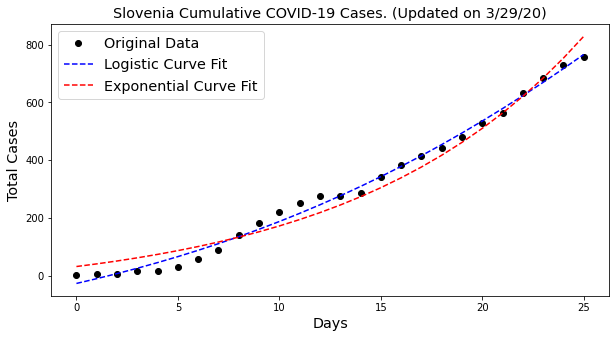



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 715
	Confirmed cases on 3/23/20 	 352
	Ratio: 2.03
	Weekly increase: 103.1 %
	Daily increase: 10.7 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9813610326166166
	Doubling Time (during middle of growth):  10.3 (± 4.37 ) days

** Based on Exponential Fit **

	R^2: 0.9794419801440896
	Doubling Time (represents overall growth):  7.9 (± 1.31 ) days


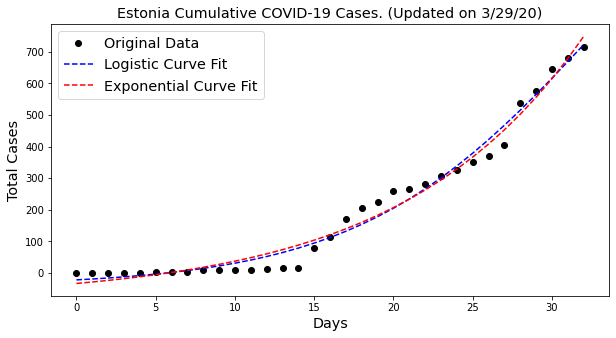



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.9961821495786501
	Doubling Time (during middle of growth):  2.81 (± 0.24 ) days


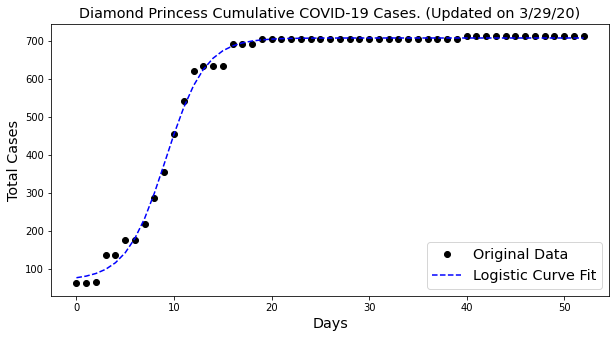



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 693
	Confirmed cases on 3/23/20 	 501
	Ratio: 1.38
	Weekly increase: 38.3 %
	Daily increase: 4.7 % per day
	Doubling Time (represents recent growth): 15.0 days

** Based on Logistic Fit**

	R^2: 0.9596672477788922
	Doubling Time (during middle of growth):  3.98 (± 1.39 ) days


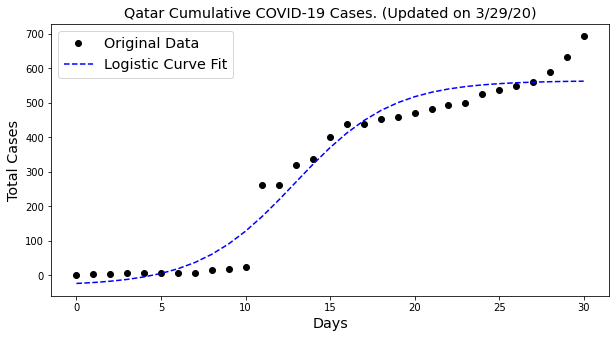



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 656
	Confirmed cases on 3/23/20 	 366
	Ratio: 1.79
	Weekly increase: 79.2 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9976353812849422
	Doubling Time (during middle of growth):  7.63 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.9877463973611392
	Doubling Time (represents overall growth):  7.17 (± 0.6 ) days


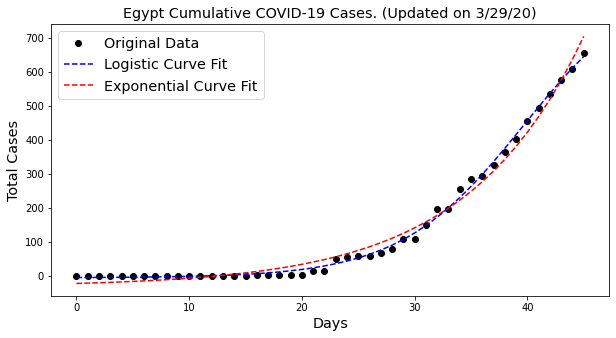



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 630
	Confirmed cases on 3/23/20 	 266
	Ratio: 2.37
	Weekly increase: 136.8 %
	Daily increase: 13.1 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.99724231786026
	Doubling Time (during middle of growth):  12.46 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.9972423179302817
	Doubling Time (represents overall growth):  6.23 (± 0.29 ) days


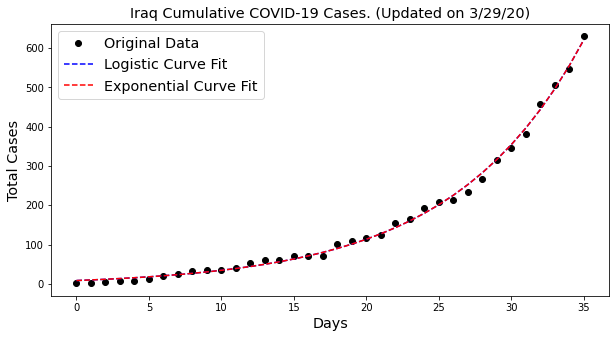



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 611
	Confirmed cases on 3/23/20 	 198
	Ratio: 3.09
	Weekly increase: 208.6 %
	Daily increase: 17.5 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Exponential Fit **

	R^2: 0.9903441026812624
	Doubling Time (represents overall growth):  4.73 (± 0.25 ) days


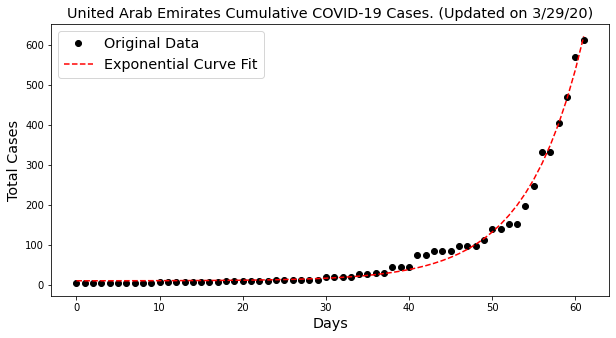



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 589
	Confirmed cases on 3/23/20 	 102
	Ratio: 5.77
	Weekly increase: 477.5 %
	Daily increase: 28.5 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.9869354229461361
	Doubling Time (represents overall growth):  3.15 (± 0.29 ) days


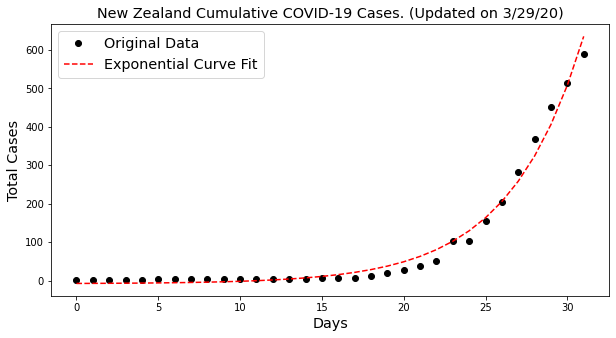



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 584
	Confirmed cases on 3/23/20 	 230
	Ratio: 2.54
	Weekly increase: 153.9 %
	Daily increase: 14.2 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.9970914903337628
	Doubling Time (during middle of growth):  5.52 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.9908845562396806
	Doubling Time (represents overall growth):  4.67 (± 0.37 ) days


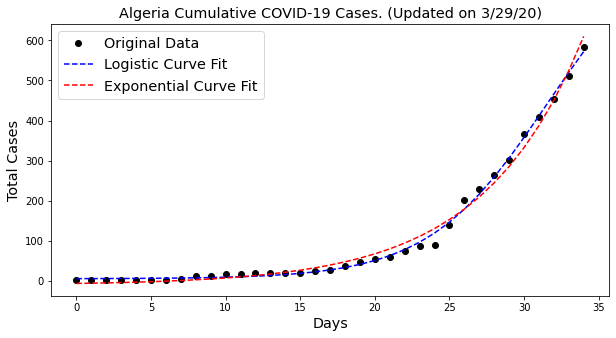



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 556
	Confirmed cases on 3/23/20 	 143
	Ratio: 3.89
	Weekly increase: 288.8 %
	Daily increase: 21.4 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9993459653244965
	Doubling Time (during middle of growth):  5.64 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.9977455620333319
	Doubling Time (represents overall growth):  3.71 (± 0.16 ) days


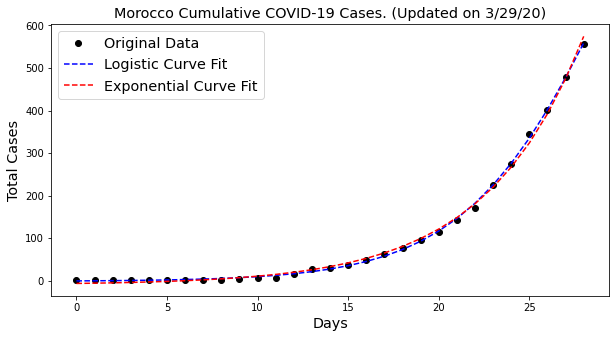



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 548
	Confirmed cases on 3/23/20 	 73
	Ratio: 7.51
	Weekly increase: 650.7 %
	Daily increase: 33.4 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Exponential Fit **

	R^2: 0.9910643685700213
	Doubling Time (represents overall growth):  2.7 (± 0.22 ) days


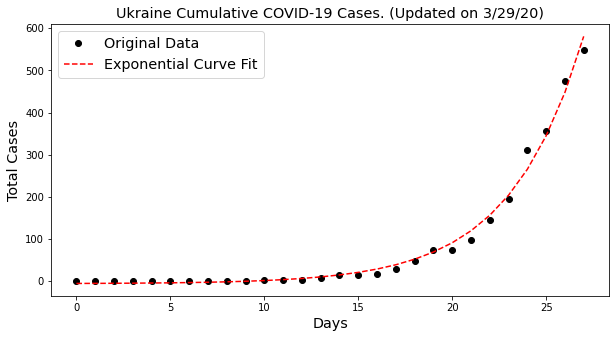



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 515
	Confirmed cases on 3/23/20 	 377
	Ratio: 1.37
	Weekly increase: 36.6 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.6 days

** Based on Logistic Fit**

	R^2: 0.9891197854470135
	Doubling Time (during middle of growth):  13.2 (± 4.66 ) days

** Based on Exponential Fit **

	R^2: 0.9848329928075203
	Doubling Time (represents overall growth):  13.03 (± 2.44 ) days


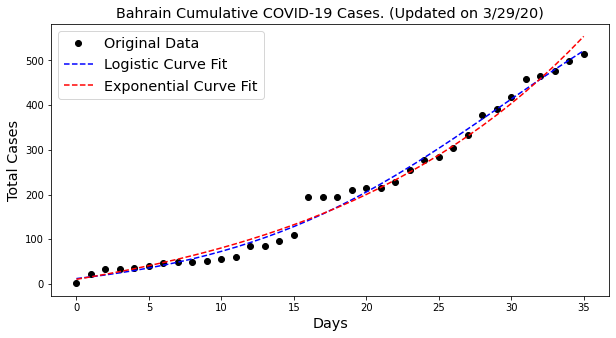



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 491
	Confirmed cases on 3/23/20 	 179
	Ratio: 2.74
	Weekly increase: 174.3 %
	Daily increase: 15.5 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9970924573014709
	Doubling Time (during middle of growth):  3.81 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.9783004093339592
	Doubling Time (represents overall growth):  4.23 (± 0.54 ) days


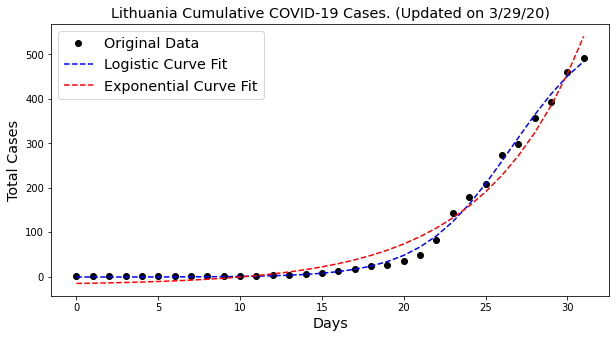



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 482
	Confirmed cases on 3/23/20 	 235
	Ratio: 2.05
	Weekly increase: 105.1 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9923096869028463
	Doubling Time (during middle of growth):  6.71 (± 1.42 ) days

** Based on Exponential Fit **

	R^2: 0.986614959904583
	Doubling Time (represents overall growth):  5.98 (± 0.75 ) days


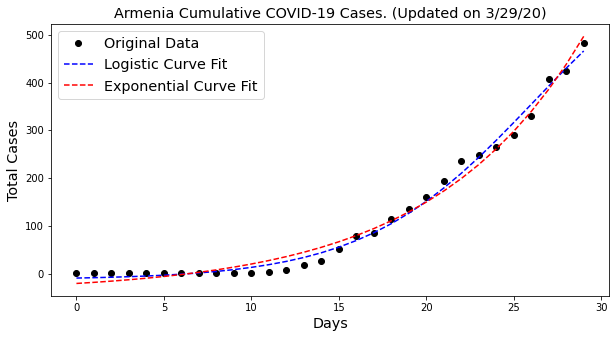



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 447
	Confirmed cases on 3/23/20 	 167
	Ratio: 2.68
	Weekly increase: 167.7 %
	Daily increase: 15.1 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.999252108532825
	Doubling Time (during middle of growth):  6.48 (± 0.5 ) days

** Based on Exponential Fit **

	R^2: 0.9970578376614759
	Doubling Time (represents overall growth):  4.74 (± 0.27 ) days


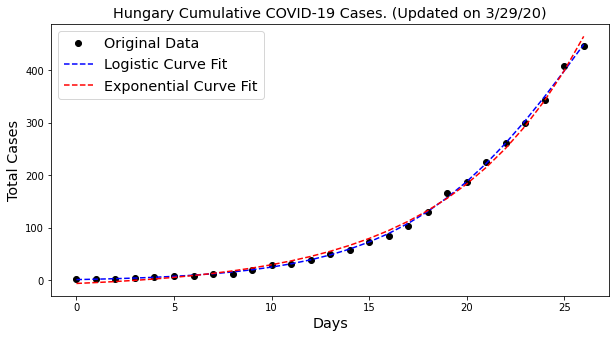



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 446
	Confirmed cases on 3/23/20 	 267
	Ratio: 1.67
	Weekly increase: 67.0 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.9955885570489091
	Doubling Time (during middle of growth):  7.61 (± 0.96 ) days

** Based on Exponential Fit **

	R^2: 0.9867767963833289
	Doubling Time (represents overall growth):  7.74 (± 0.83 ) days


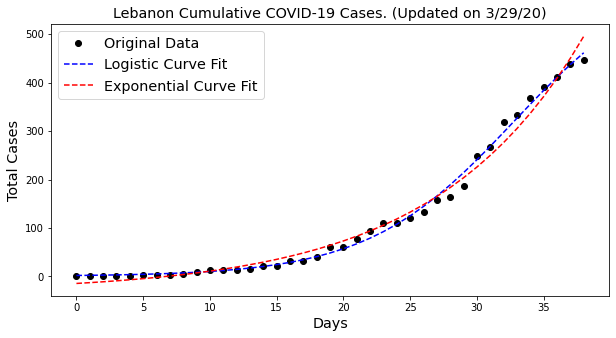



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 376
	Confirmed cases on 3/23/20 	 180
	Ratio: 2.09
	Weekly increase: 108.9 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9979060526844584
	Doubling Time (during middle of growth):  6.38 (± 0.7 ) days

** Based on Exponential Fit **

	R^2: 0.9915162137718927
	Doubling Time (represents overall growth):  6.05 (± 0.63 ) days


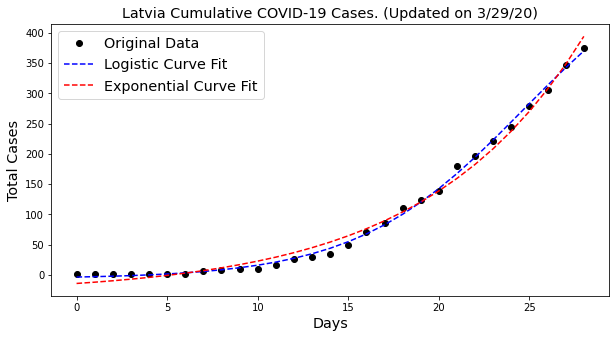



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 370
	Confirmed cases on 3/23/20 	 133
	Ratio: 2.78
	Weekly increase: 178.2 %
	Daily increase: 15.7 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9967803514560103
	Doubling Time (during middle of growth):  4.96 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.9865942631329627
	Doubling Time (represents overall growth):  4.7 (± 0.54 ) days


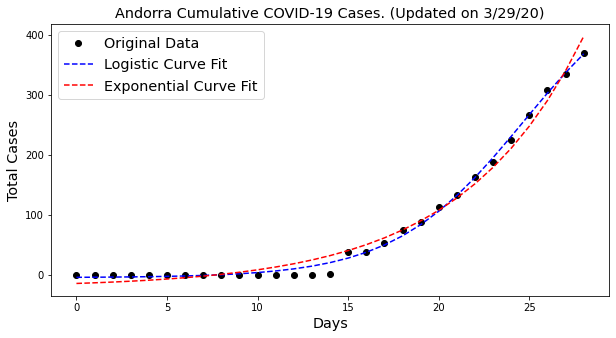



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 368
	Confirmed cases on 3/23/20 	 136
	Ratio: 2.71
	Weekly increase: 170.6 %
	Daily increase: 15.3 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9928300262613716
	Doubling Time (during middle of growth):  8.17 (± 2.61 ) days

** Based on Exponential Fit **

	R^2: 0.9923884922022301
	Doubling Time (represents overall growth):  4.99 (± 0.5 ) days


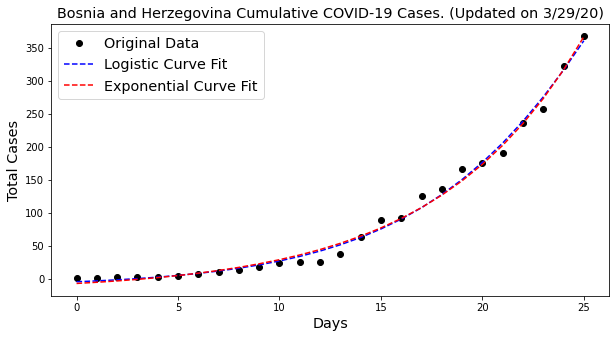



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 359
	Confirmed cases on 3/23/20 	 201
	Ratio: 1.79
	Weekly increase: 78.6 %
	Daily increase: 8.6 % per day
	Doubling Time (represents recent growth): 8.4 days

** Based on Logistic Fit**

	R^2: 0.9963230748547396
	Doubling Time (during middle of growth):  6.74 (± 1.36 ) days

** Based on Exponential Fit **

	R^2: 0.9889093262518719
	Doubling Time (represents overall growth):  9.07 (± 2.02 ) days


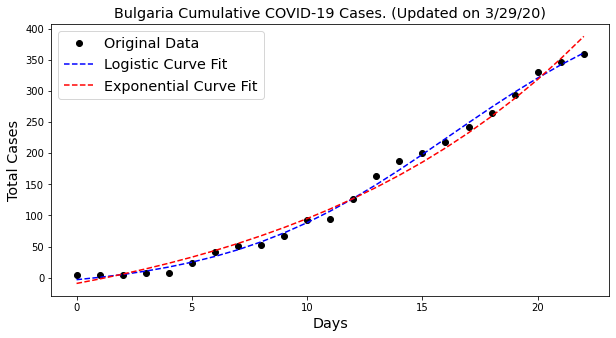



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 336
	Confirmed cases on 3/23/20 	 186
	Ratio: 1.81
	Weekly increase: 80.6 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9908569431046582
	Doubling Time (during middle of growth):  9.01 (± 3.49 ) days

** Based on Exponential Fit **

	R^2: 0.9868533711488254
	Doubling Time (represents overall growth):  10.26 (± 2.45 ) days


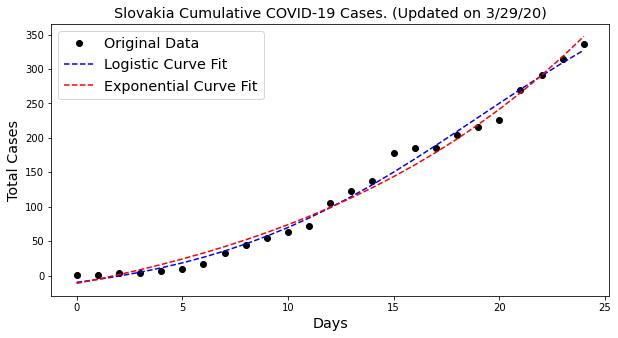



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 330
	Confirmed cases on 3/23/20 	 158
	Ratio: 2.09
	Weekly increase: 108.9 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9983410940183212
	Doubling Time (during middle of growth):  5.41 (± 0.55 ) days

** Based on Exponential Fit **

	R^2: 0.9887343429795762
	Doubling Time (represents overall growth):  6.51 (± 0.99 ) days


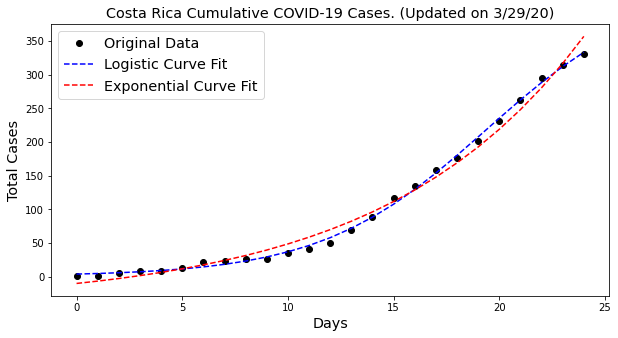



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 312
	Confirmed cases on 3/23/20 	 89
	Ratio: 3.51
	Weekly increase: 250.6 %
	Daily increase: 19.6 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9946346994804794
	Doubling Time (during middle of growth):  3.95 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.9816883339876672
	Doubling Time (represents overall growth):  4.28 (± 0.59 ) days


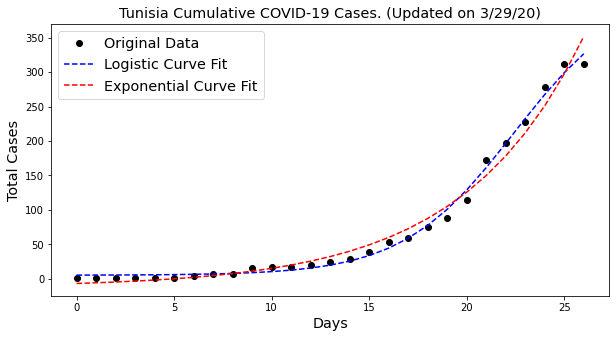



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 310
	Confirmed cases on 3/23/20 	 162
	Ratio: 1.91
	Weekly increase: 91.4 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9899785058227155
	Doubling Time (during middle of growth):  13.64 (± 25.66 ) days

** Based on Exponential Fit **

	R^2: 0.9740995649563543
	Doubling Time (represents overall growth):  7.66 (± 3.55 ) days


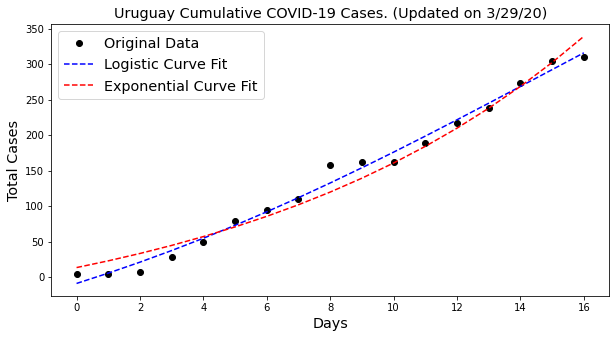



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 306
	Confirmed cases on 3/23/20 	 195
	Ratio: 1.57
	Weekly increase: 56.9 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.8 days

** Based on Exponential Fit **

	R^2: 0.9786539535476971
	Doubling Time (represents overall growth):  6.87 (± 0.53 ) days


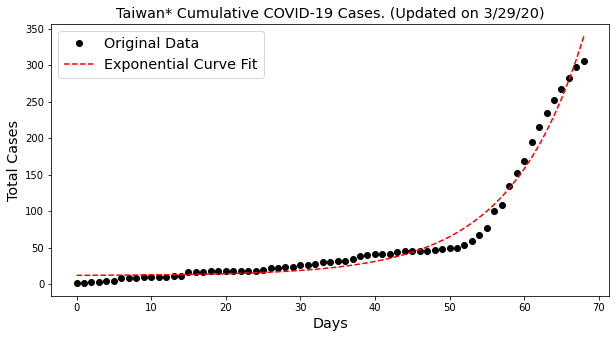



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 302
	Confirmed cases on 3/23/20 	 62
	Ratio: 4.87
	Weekly increase: 387.1 %
	Daily increase: 25.4 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9749630050181588
	Doubling Time (during middle of growth):  3.85 (± 2.14 ) days

** Based on Exponential Fit **

	R^2: 0.9735781321922733
	Doubling Time (represents overall growth):  2.88 (± 0.62 ) days


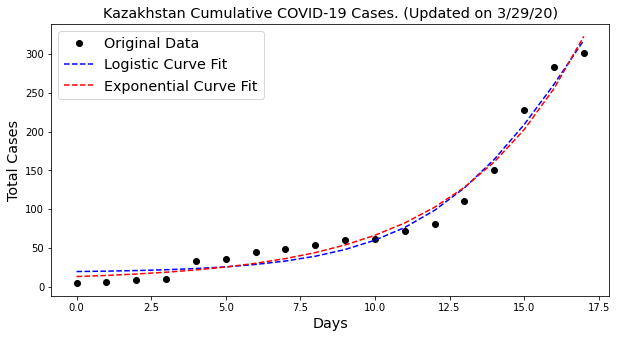



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 298
	Confirmed cases on 3/23/20 	 109
	Ratio: 2.73
	Weekly increase: 173.4 %
	Daily increase: 15.5 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9985374200826024
	Doubling Time (during middle of growth):  7.24 (± 1.08 ) days

** Based on Exponential Fit **

	R^2: 0.9971889345622379
	Doubling Time (represents overall growth):  5.35 (± 0.39 ) days


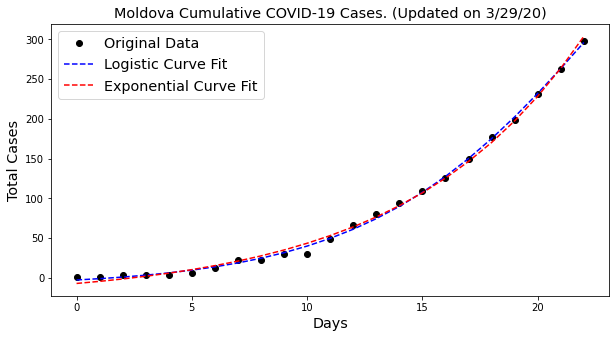



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 285
	Confirmed cases on 3/23/20 	 136
	Ratio: 2.1
	Weekly increase: 109.6 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9983133606293073
	Doubling Time (during middle of growth):  4.49 (± 0.33 ) days

** Based on Exponential Fit **

	R^2: 0.9792289316152849
	Doubling Time (represents overall growth):  5.32 (± 0.68 ) days


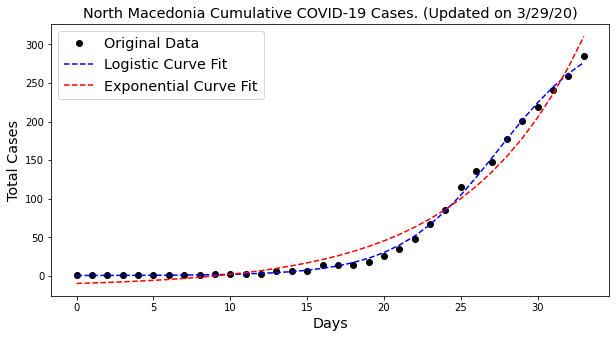



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 273
	Confirmed cases on 3/23/20 	 72
	Ratio: 3.79
	Weekly increase: 279.2 %
	Daily increase: 21.0 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9950937653782314
	Doubling Time (during middle of growth):  7.3 (± 1.05 ) days

** Based on Exponential Fit **

	R^2: 0.995093765866356
	Doubling Time (represents overall growth):  3.65 (± 0.22 ) days


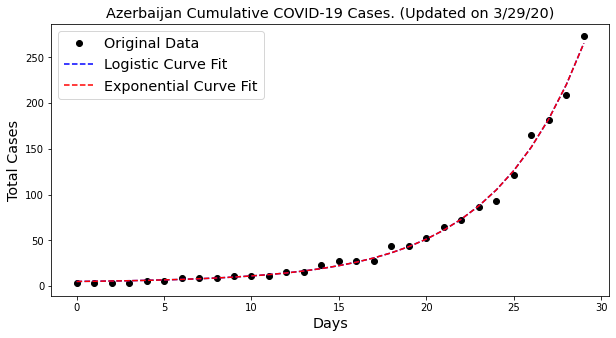



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 268
	Confirmed cases on 3/23/20 	 127
	Ratio: 2.11
	Weekly increase: 111.0 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9950883043499845
	Doubling Time (during middle of growth):  4.6 (± 0.66 ) days

** Based on Exponential Fit **

	R^2: 0.9728995679750563
	Doubling Time (represents overall growth):  6.39 (± 1.29 ) days


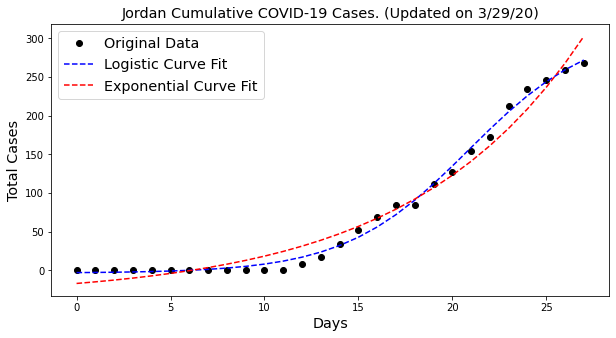



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 266
	Confirmed cases on 3/23/20 	 189
	Ratio: 1.41
	Weekly increase: 40.7 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.2 days

** Based on Logistic Fit**

	R^2: 0.9845982104699069
	Doubling Time (during middle of growth):  15.39 (± 8.09 ) days

** Based on Exponential Fit **

	R^2: 0.9838047396729221
	Doubling Time (represents overall growth):  14.75 (± 3.16 ) days


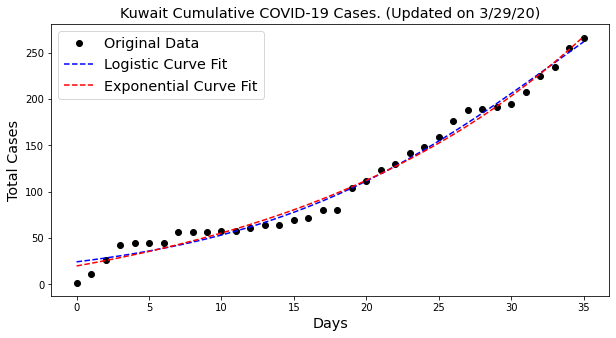



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 246
	Confirmed cases on 3/23/20 	 99
	Ratio: 2.48
	Weekly increase: 148.5 %
	Daily increase: 13.9 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9973872574379066
	Doubling Time (during middle of growth):  4.68 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.9870772174827923
	Doubling Time (represents overall growth):  6.04 (± 1.17 ) days


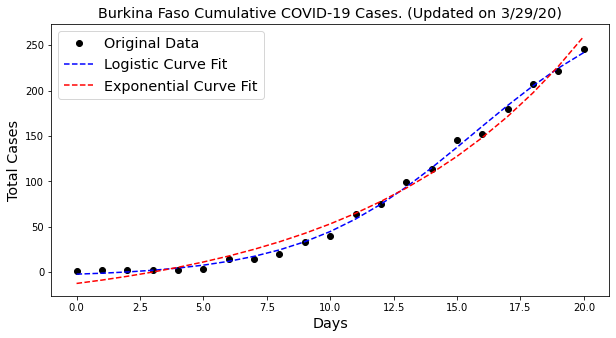



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 230
	Confirmed cases on 3/23/20 	 116
	Ratio: 1.98
	Weekly increase: 98.3 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9957312118614627
	Doubling Time (during middle of growth):  17.06 (± 17.25 ) days

** Based on Exponential Fit **

	R^2: 0.9957312128534458
	Doubling Time (represents overall growth):  8.53 (± 1.18 ) days


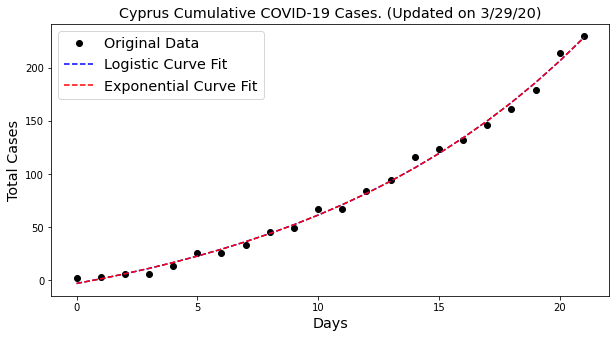



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 230
	Confirmed cases on 3/23/20 	 187
	Ratio: 1.23
	Weekly increase: 23.0 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.4 days

** Based on Logistic Fit**

	R^2: 0.9941559154947607
	Doubling Time (during middle of growth):  9.54 (± 1.9 ) days

** Based on Exponential Fit **

	R^2: 0.983368461087295
	Doubling Time (represents overall growth):  16.56 (± 4.57 ) days


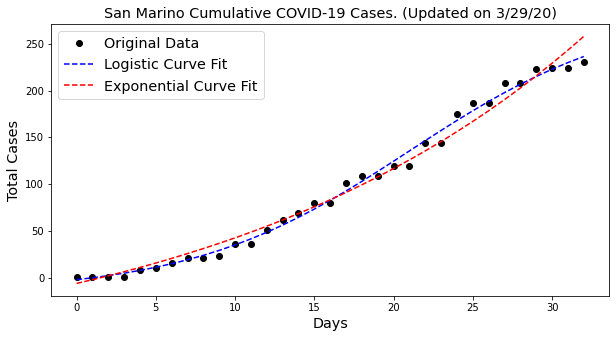



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 223
	Confirmed cases on 3/23/20 	 104
	Ratio: 2.14
	Weekly increase: 114.4 %
	Daily increase: 11.5 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9884099115335643
	Doubling Time (during middle of growth):  8.18 (± 4.15 ) days

** Based on Exponential Fit **

	R^2: 0.986974143224522
	Doubling Time (represents overall growth):  8.1 (± 1.88 ) days


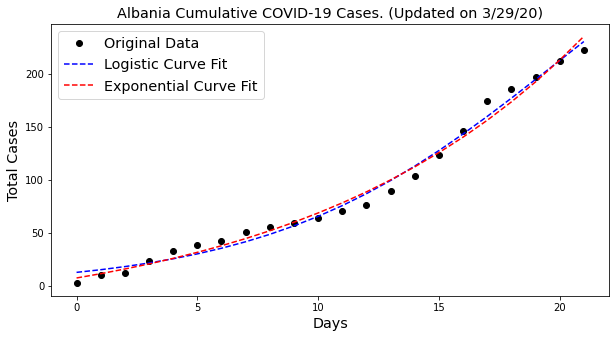



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 203
	Confirmed cases on 3/23/20 	 123
	Ratio: 1.65
	Weekly increase: 65.0 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.992781873402419
	Doubling Time (during middle of growth):  9.78 (± 1.14 ) days

** Based on Exponential Fit **

	R^2: 0.9890176693361311
	Doubling Time (represents overall growth):  7.43 (± 0.42 ) days


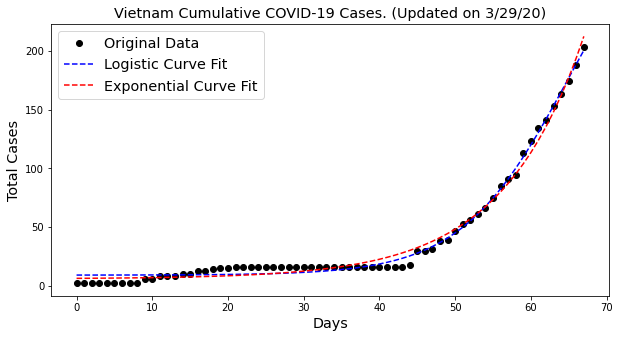



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 179
	Confirmed cases on 3/23/20 	 66
	Ratio: 2.71
	Weekly increase: 171.2 %
	Daily increase: 15.3 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.991945257356484
	Doubling Time (during middle of growth):  7.26 (± 1.47 ) days

** Based on Exponential Fit **

	R^2: 0.990684138437922
	Doubling Time (represents overall growth):  4.79 (± 0.37 ) days


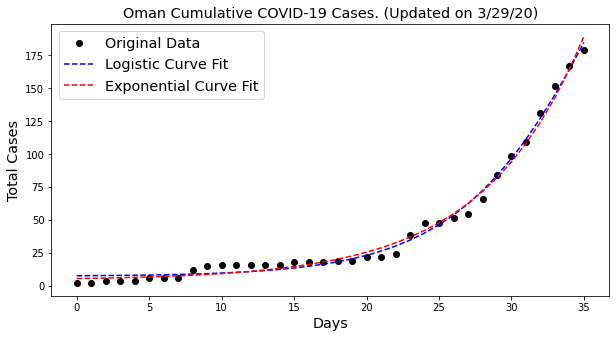



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 170
	Confirmed cases on 3/23/20 	 40
	Ratio: 4.25
	Weekly increase: 325.0 %
	Daily increase: 23.0 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.9791414068161343
	Doubling Time (during middle of growth):  6.83 (± 2.22 ) days

** Based on Exponential Fit **

	R^2: 0.9782572200582035
	Doubling Time (represents overall growth):  4.27 (± 0.49 ) days


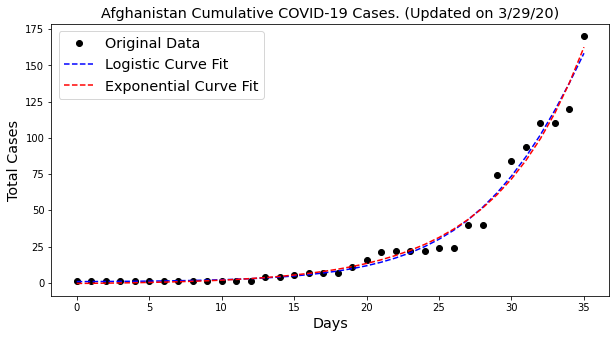



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 170
	Confirmed cases on 3/23/20 	 40
	Ratio: 4.25
	Weekly increase: 325.0 %
	Daily increase: 23.0 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.993973947327302
	Doubling Time (during middle of growth):  6.21 (± 2.43 ) days

** Based on Exponential Fit **

	R^2: 0.9939533873052401
	Doubling Time (represents overall growth):  3.24 (± 0.33 ) days


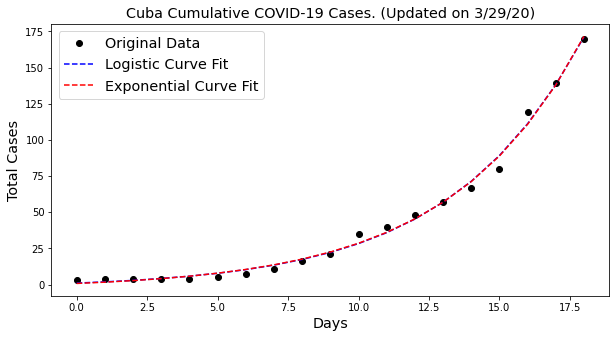



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 168
	Confirmed cases on 3/23/20 	 25
	Ratio: 6.72
	Weekly increase: 572.0 %
	Daily increase: 31.3 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.9638719906014976
	Doubling Time (during middle of growth):  3.73 (± 1.98 ) days

** Based on Exponential Fit **

	R^2: 0.9545433124027487
	Doubling Time (represents overall growth):  3.79 (± 1.09 ) days


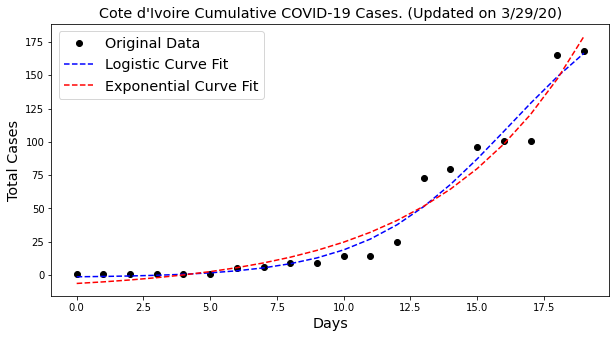



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 162
	Confirmed cases on 3/23/20 	 79
	Ratio: 2.05
	Weekly increase: 105.1 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9944624379417221
	Doubling Time (during middle of growth):  6.1 (± 1.06 ) days

** Based on Exponential Fit **

	R^2: 0.9873829861947068
	Doubling Time (represents overall growth):  6.01 (± 0.76 ) days


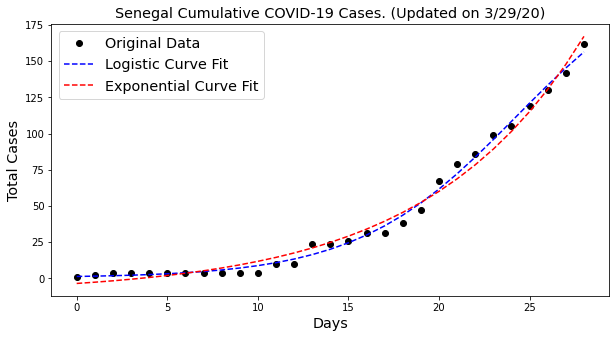



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 156
	Confirmed cases on 3/23/20 	 107
	Ratio: 1.46
	Weekly increase: 45.8 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.9 days

** Based on Logistic Fit**

	R^2: 0.9978952623587685
	Doubling Time (during middle of growth):  4.57 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.9745593286112106
	Doubling Time (represents overall growth):  13.33 (± 5.95 ) days


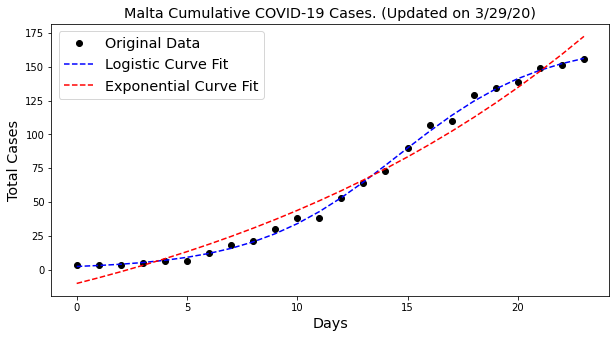



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 152
	Confirmed cases on 3/23/20 	 27
	Ratio: 5.63
	Weekly increase: 463.0 %
	Daily increase: 28.0 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.9943826674384387
	Doubling Time (during middle of growth):  1.27 (± 0.25 ) days


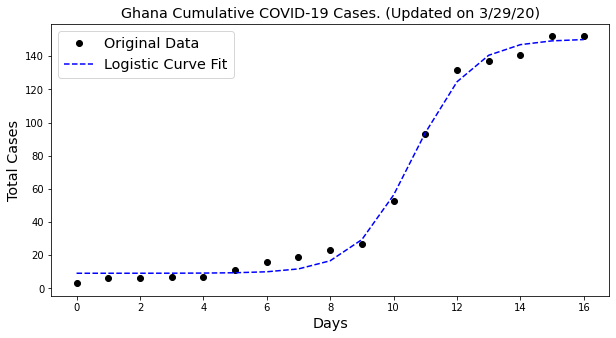



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 152
	Confirmed cases on 3/23/20 	 81
	Ratio: 1.88
	Weekly increase: 87.7 %
	Daily increase: 9.4 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.9509355891886264
	Doubling Time (during middle of growth):  8.72 (± 5.06 ) days


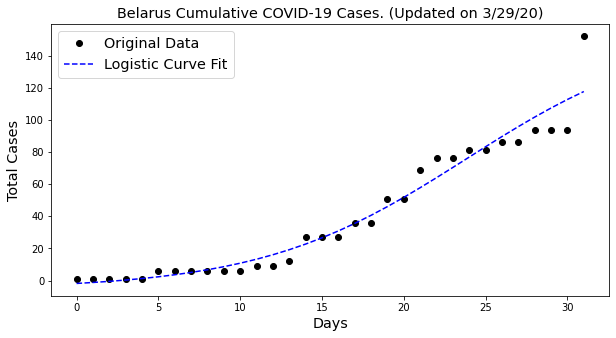



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 149
	Confirmed cases on 3/23/20 	 46
	Ratio: 3.24
	Weekly increase: 223.9 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9801158639387446
	Doubling Time (during middle of growth):  9.13 (± 6.93 ) days

** Based on Exponential Fit **

	R^2: 0.9801158659219888
	Doubling Time (represents overall growth):  4.57 (± 1.3 ) days


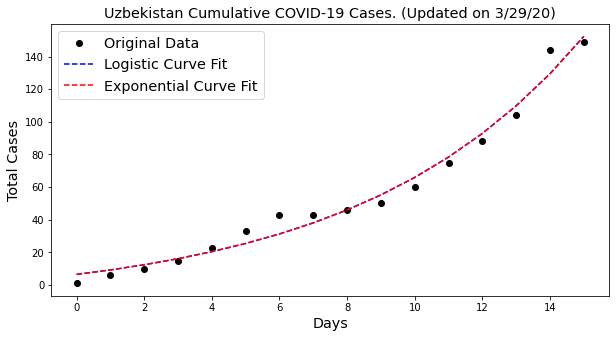



Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 139
	Confirmed cases on 3/23/20 	 30
	Ratio: 4.63
	Weekly increase: 363.3 %
	Daily increase: 24.5 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.9893406975478362
	Doubling Time (during middle of growth):  5.93 (± inf ) days

** Based on Exponential Fit **

	R^2: 0.9893406981669808
	Doubling Time (represents overall growth):  2.97 (± 0.36 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


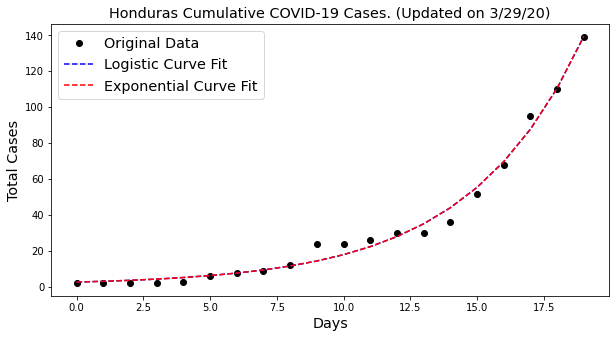



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 139
	Confirmed cases on 3/23/20 	 56
	Ratio: 2.48
	Weekly increase: 148.2 %
	Daily increase: 13.9 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9789384900585225
	Doubling Time (during middle of growth):  5.39 (± 2.1 ) days

** Based on Exponential Fit **

	R^2: 0.9738552890073214
	Doubling Time (represents overall growth):  4.58 (± 0.85 ) days


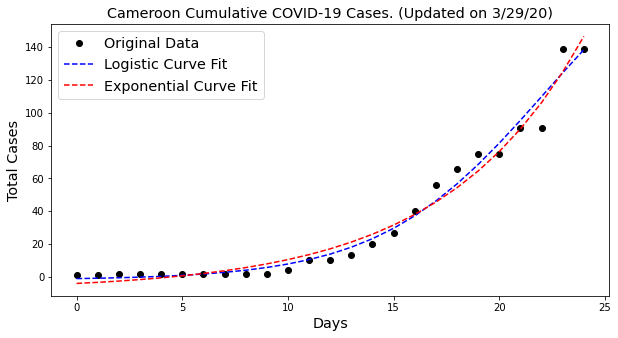



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 135
	Confirmed cases on 3/23/20 	 77
	Ratio: 1.75
	Weekly increase: 75.3 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9882159943043666
	Doubling Time (during middle of growth):  24.76 (± 156.19 ) days

** Based on Exponential Fit **

	R^2: 0.9717948935805095
	Doubling Time (represents overall growth):  13.41 (± 10.92 ) days


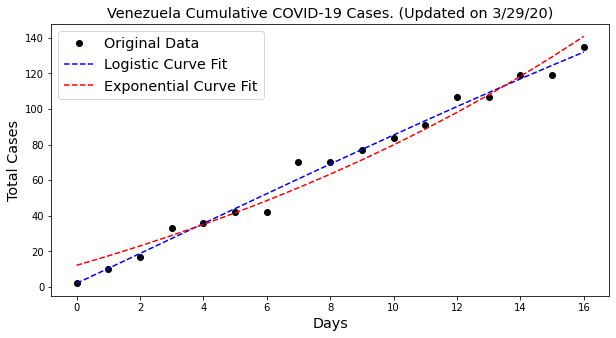



Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 131
	Confirmed cases on 3/23/20 	 40
	Ratio: 3.28
	Weekly increase: 227.5 %
	Daily increase: 18.5 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.99369340639622
	Doubling Time (during middle of growth):  5.41 (± 0.97 ) days

** Based on Exponential Fit **

	R^2: 0.9916628052500477
	Doubling Time (represents overall growth):  3.53 (± 0.26 ) days


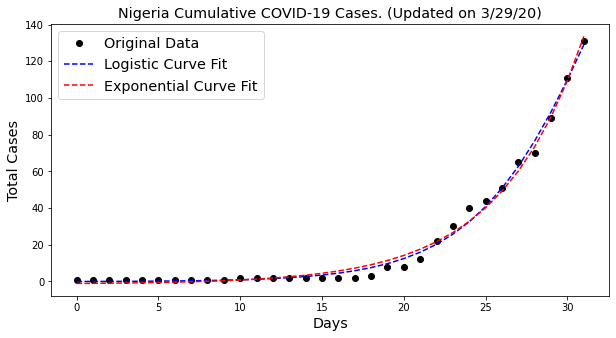



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 128
	Confirmed cases on 3/23/20 	 36
	Ratio: 3.56
	Weekly increase: 255.6 %
	Daily increase: 19.9 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.9856884876993406
	Doubling Time (during middle of growth):  3.62 (± 1.99 ) days

** Based on Exponential Fit **

	R^2: 0.9787636005223529
	Doubling Time (represents overall growth):  8.2 (± 5.5 ) days


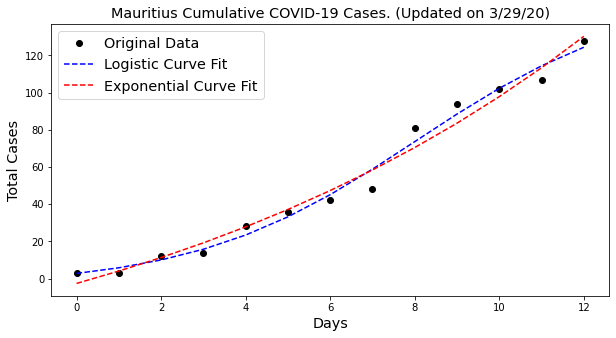



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 127
	Confirmed cases on 3/23/20 	 91
	Ratio: 1.4
	Weekly increase: 39.6 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.6 days

** Based on Logistic Fit**

	R^2: 0.9908373757236029
	Doubling Time (during middle of growth):  23.45 (± 60.87 ) days


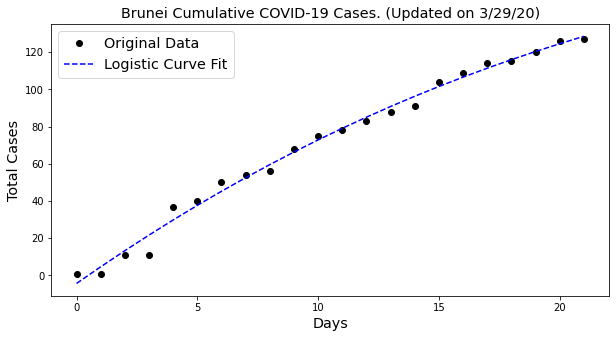



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 122
	Confirmed cases on 3/23/20 	 97
	Ratio: 1.26
	Weekly increase: 25.8 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.2 days

** Based on Logistic Fit**

	R^2: 0.9960146331932879
	Doubling Time (during middle of growth):  3.5 (± 0.28 ) days


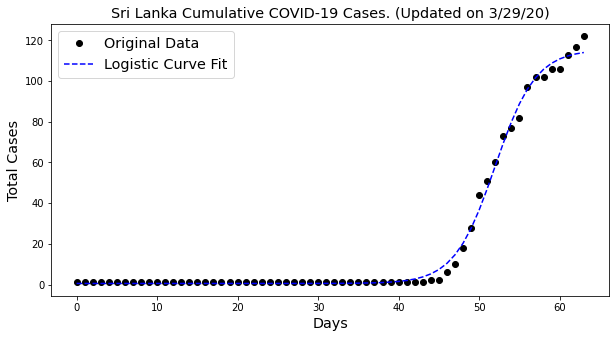



West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 116
	Confirmed cases on 3/23/20 	 59
	Ratio: 1.97
	Weekly increase: 96.6 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9652867652742538
	Doubling Time (during middle of growth):  14.56 (± 4.64 ) days

** Based on Exponential Fit **

	R^2: 0.9652867661209519
	Doubling Time (represents overall growth):  7.28 (± 2.03 ) days


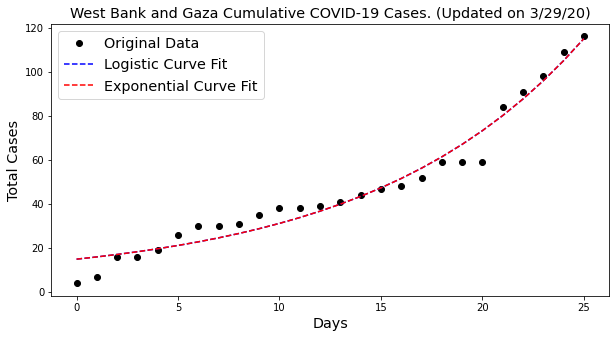



Cambodia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 107
	Confirmed cases on 3/23/20 	 87
	Ratio: 1.23
	Weekly increase: 23.0 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.4 days

** Based on Logistic Fit**

	R^2: 0.9930616198354455
	Doubling Time (during middle of growth):  2.99 (± 0.32 ) days


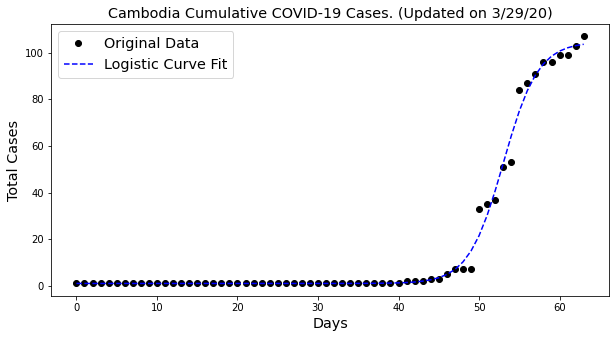



Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/30/20 	 103
	Confirmed cases on 3/23/20 	 61
	Ratio: 1.69
	Weekly increase: 68.9 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.3 days

** Based on Logistic Fit**

	R^2: 0.9917897352699525
	Doubling Time (during middle of growth):  14.78 (± 6.12 ) days

** Based on Exponential Fit **

	R^2: 0.9911664507161244
	Doubling Time (represents overall growth):  11.05 (± 1.48 ) days


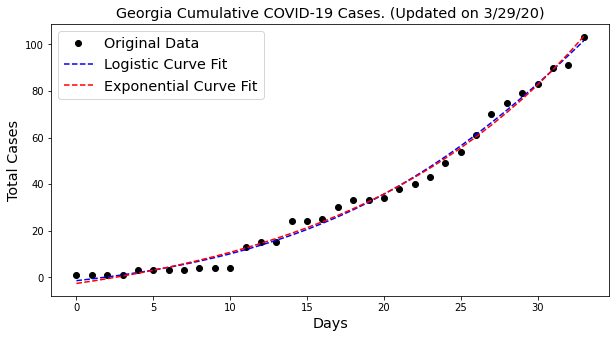

In [75]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
        
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


                 Countries  Inferred Doubling Time  Recent Doubling Time
0                    China                     6.5                1000.0
1                    Italy                     4.8                   5.6
2                       US                     2.2                   2.2
3                    Spain                     4.9                   3.7
4                  Germany                     3.3                   3.3
5                     Iran                     7.7                  11.0
6                   France                     4.0                   3.8
7             Korea, South                     NaN                  56.3
8              Switzerland                     3.4                   4.1
9           United Kingdom                     3.1            

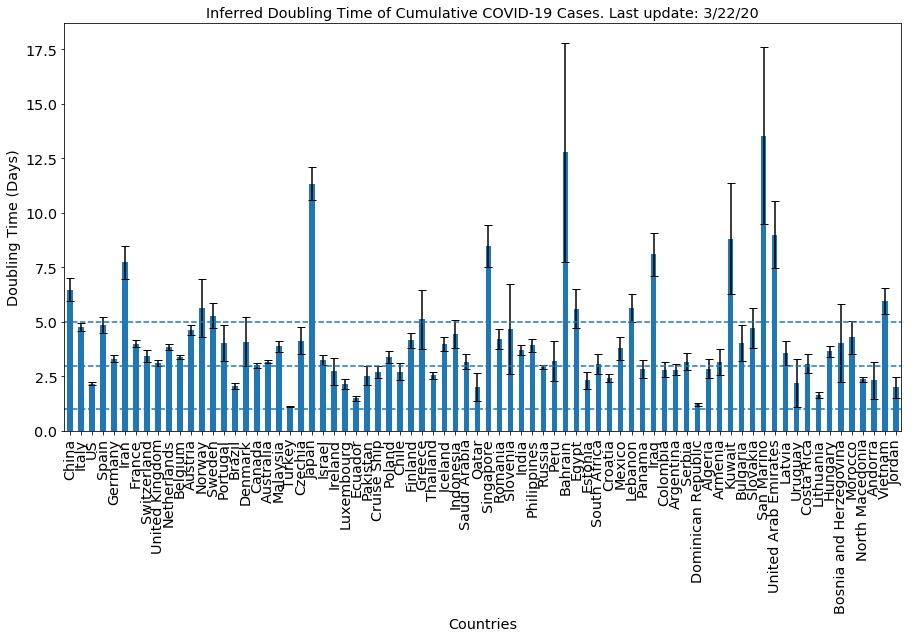

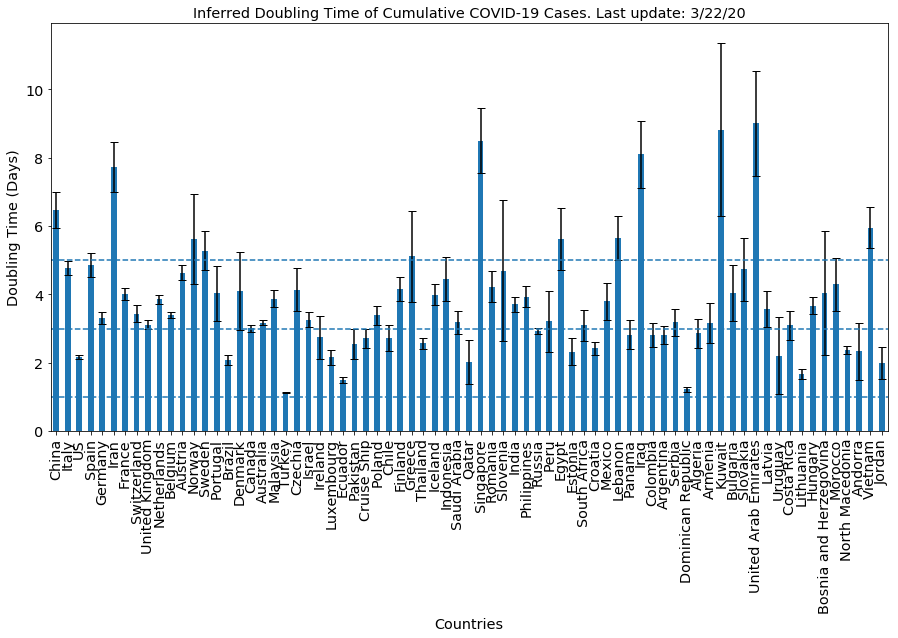

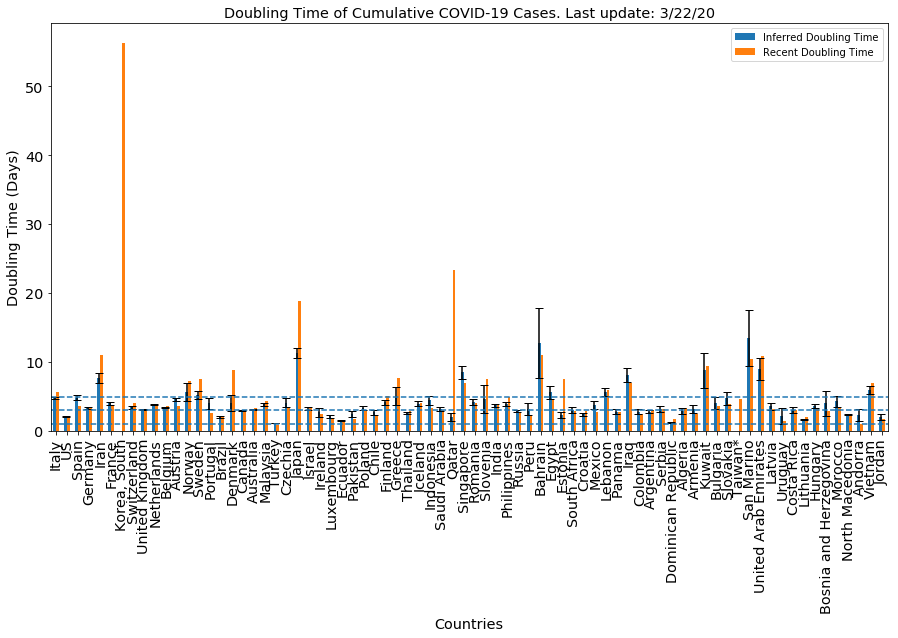

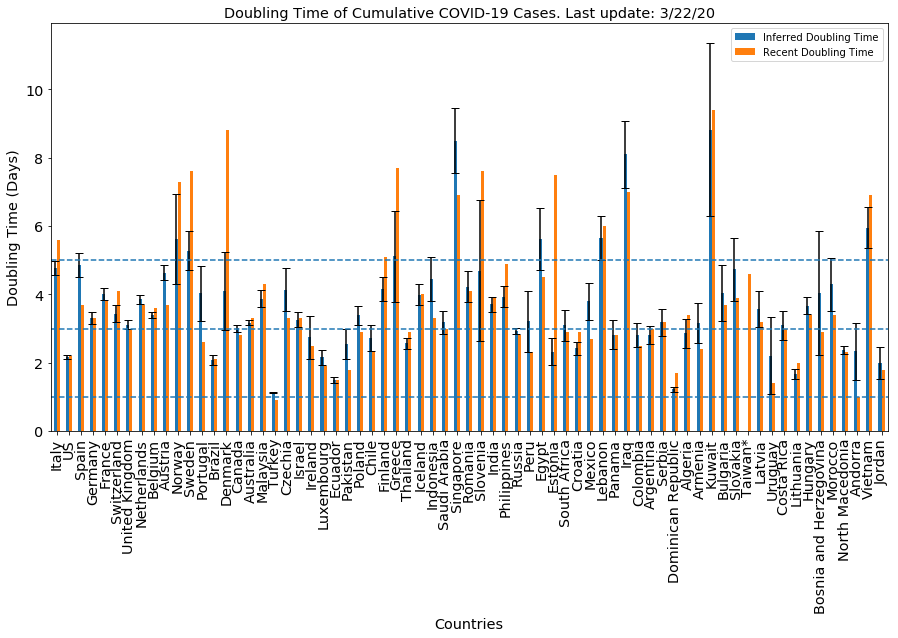

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [65]:
uscases = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

# For some reason they change column names, change them back.
uscases.rename(columns={
    'Country_Region':'Country/Region',
    'Province_State':'Province/State',
    'Long_':'Long'
}, inplace=True)


# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

# global
# Province/State,Country/Region,Lat,Long,1/22/20

# US
# UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/2020

# Province/State  Country/Region      Lat     Long  1/22/20
uscases = uscases.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'])

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()

mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/29/20


3/29/20
Province/State               
New York                59648
New Jersey              13386
California               5852
Michigan                 5488
Massachusetts            4963
Illinois                 4596
Washington               4465
Florida                  4246
Louisiana                3540
Pennsylvania             3432
Texas                    2792
Recovered                2665
Georgia                  2651
Colorado                 2307
Connecticut              1993
Tennessee                1720
Ohio                     1653
Indiana                  1513
Maryland                 1239
North Carolina           1191
Wisconsin                1164
Nevada                    920
Arizona                   919
Missouri                  915
Virginia                  890
Alabama                   825
South Carolina            774
Mississippi               759
Utah                      720
Oregon                    548
Minnesota                 503
Kentucky                  438
Oklahoma                  429
Arkansas                  426
District of Columbia      342
Iowa                      336
Kansas                    330
Rhode Island              294
Idaho                     281
Maine                     253
New Mexico                237
Vermont                   235
Delaware                  232
New Hampshire             214
Montana                   154
Hawaii                    149
Puerto Rico               127
West Virginia             113
Nebraska                  108
Grand Princess            103
Alaska                    102
North Dakota               98
South Dakota               90
Wyoming                    86
Guam                       56
Diamond Princess           49

## Curve Fitting US COVID-19 Cases

                      3/29/20
Province/State               
New York                59648
New Jersey              13386
California               5852
Michigan                 5488
Massachusetts            4963
Illinois                 4596
Washington               4465
Florida                  4246
Louisiana                3540
Pennsylvania             3432
Texas                    2792
Recovered                2665
Georgia                  2651
Colorado                 2307
Connecticut              1993
Tennessee                1720
Ohio                     1653
Indiana                  1513
Maryland                 1239
North Carolina           1191
Wisconsin                1164
Nevada                    920
Arizona                   919
Missouri                  915
Virginia                  890
Alabama                   825
South Carolina            774
Mississippi               759
Utah                      720
Oregon                    548
Minnesota                 503
Kentucky  

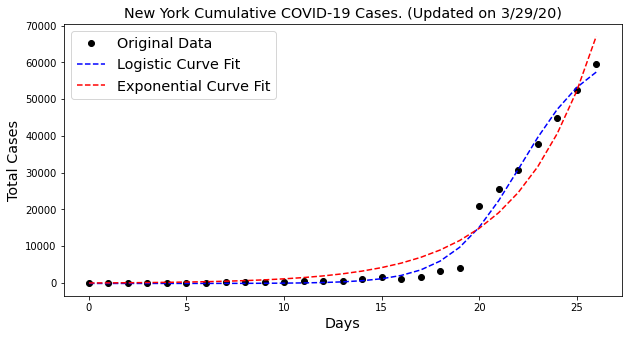



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 13386
	Confirmed cases on 3/21/20 	 1327
	Ratio: 10.09
	Weekly increase: 908.7 %
	Daily increase: 39.1 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.9981047298368013
	Doubling Time (during middle of growth):  3.22 (± 0.34 ) days

** Based on Exponential Fit **

	R^2: 0.9905935700630691
	Doubling Time (represents overall growth):  2.52 (± 0.24 ) days


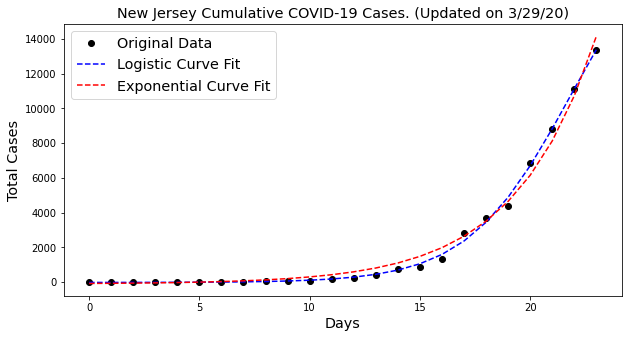



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 5852
	Confirmed cases on 3/21/20 	 1405
	Ratio: 4.17
	Weekly increase: 316.5 %
	Daily increase: 22.6 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.9938565411438138
	Doubling Time (represents overall growth):  3.69 (± 0.15 ) days


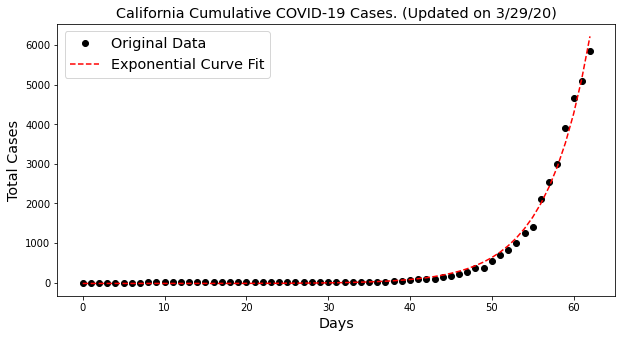



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 5488
	Confirmed cases on 3/21/20 	 540
	Ratio: 10.16
	Weekly increase: 916.3 %
	Daily increase: 39.3 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.9962155234249631
	Doubling Time (during middle of growth):  3.43 (± 0.65 ) days

** Based on Exponential Fit **

	R^2: 0.986325358591826
	Doubling Time (represents overall growth):  2.74 (± 0.42 ) days


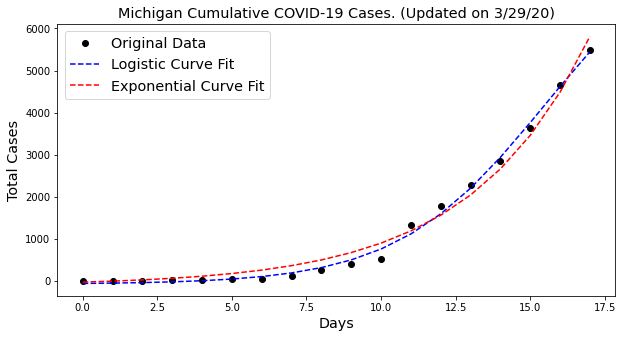



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 4963
	Confirmed cases on 3/21/20 	 522
	Ratio: 9.51
	Weekly increase: 850.8 %
	Daily increase: 38.0 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.992742053252727
	Doubling Time (represents overall growth):  2.48 (± 0.12 ) days


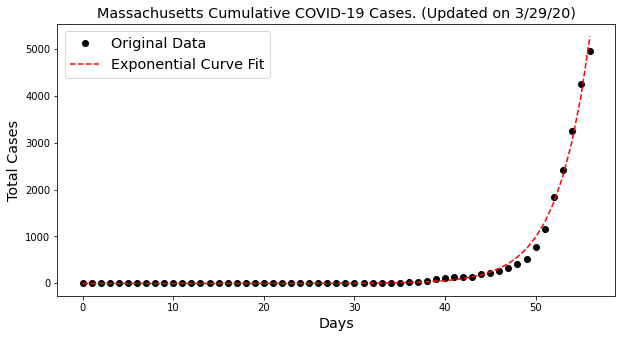



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 4596
	Confirmed cases on 3/21/20 	 753
	Ratio: 6.1
	Weekly increase: 510.4 %
	Daily increase: 29.5 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.9933526691431914
	Doubling Time (represents overall growth):  2.91 (± 0.12 ) days


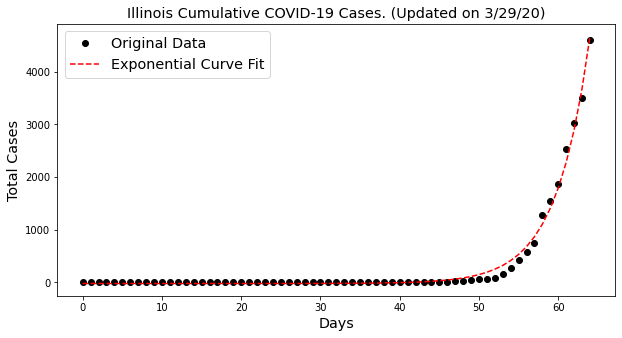



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 4465
	Confirmed cases on 3/21/20 	 1793
	Ratio: 2.49
	Weekly increase: 149.0 %
	Daily increase: 13.9 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Exponential Fit **

	R^2: 0.995284273418546
	Doubling Time (represents overall growth):  4.9 (± 0.17 ) days


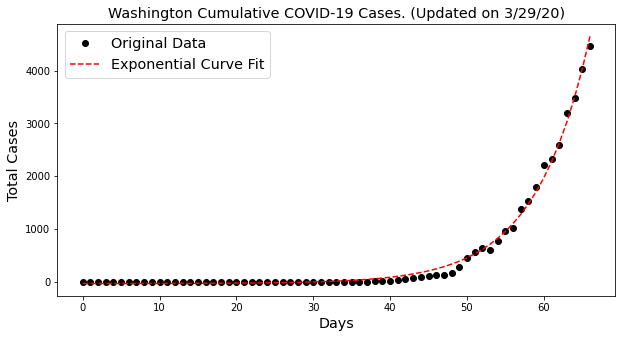



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 4246
	Confirmed cases on 3/21/20 	 763
	Ratio: 5.56
	Weekly increase: 456.5 %
	Daily increase: 27.8 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.997296423107764
	Doubling Time (during middle of growth):  3.93 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.9923765681224599
	Doubling Time (represents overall growth):  2.99 (± 0.23 ) days


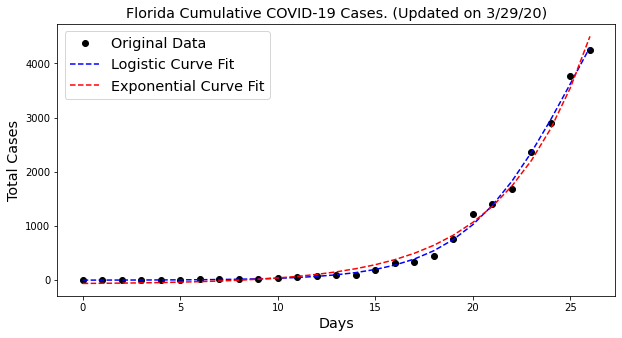



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 3540
	Confirmed cases on 3/21/20 	 763
	Ratio: 4.64
	Weekly increase: 364.0 %
	Daily increase: 24.5 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.9987191741598529
	Doubling Time (during middle of growth):  3.56 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.9816022653595677
	Doubling Time (represents overall growth):  3.18 (± 0.6 ) days


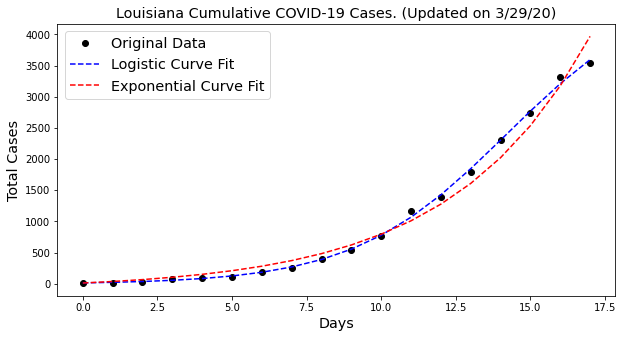



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 3432
	Confirmed cases on 3/21/20 	 399
	Ratio: 8.6
	Weekly increase: 760.2 %
	Daily increase: 36.0 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.9995056719945932
	Doubling Time (during middle of growth):  3.24 (± 0.18 ) days

** Based on Exponential Fit **

	R^2: 0.9926143214859742
	Doubling Time (represents overall growth):  2.72 (± 0.24 ) days


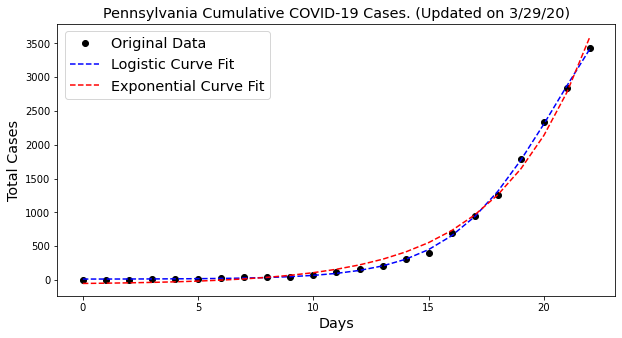



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 2792
	Confirmed cases on 3/21/20 	 582
	Ratio: 4.8
	Weekly increase: 379.7 %
	Daily increase: 25.1 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9991457815452005
	Doubling Time (during middle of growth):  4.14 (± 0.31 ) days

** Based on Exponential Fit **

	R^2: 0.9947183832026842
	Doubling Time (represents overall growth):  3.17 (± 0.23 ) days


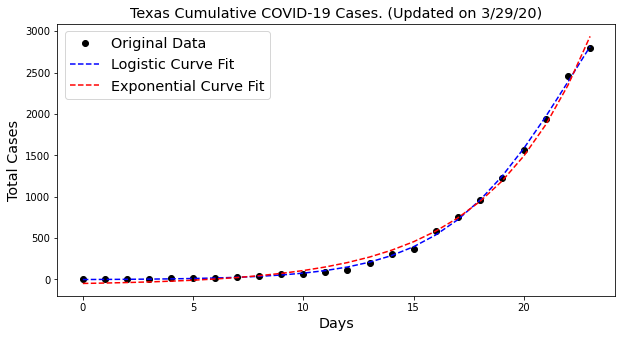



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 2651
	Confirmed cases on 3/21/20 	 555
	Ratio: 4.78
	Weekly increase: 377.7 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9987995215546659
	Doubling Time (during middle of growth):  4.11 (± 0.34 ) days

** Based on Exponential Fit **

	R^2: 0.9926872103326291
	Doubling Time (represents overall growth):  3.36 (± 0.28 ) days


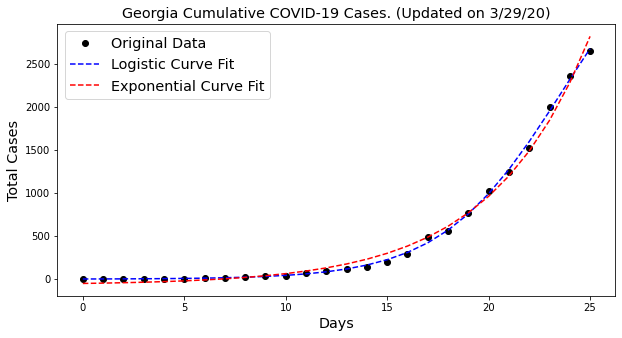



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 2307
	Confirmed cases on 3/21/20 	 475
	Ratio: 4.86
	Weekly increase: 385.7 %
	Daily increase: 25.3 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.991677469930575
	Doubling Time (during middle of growth):  5.48 (± 1.64 ) days

** Based on Exponential Fit **

	R^2: 0.990989324428527
	Doubling Time (represents overall growth):  3.39 (± 0.35 ) days


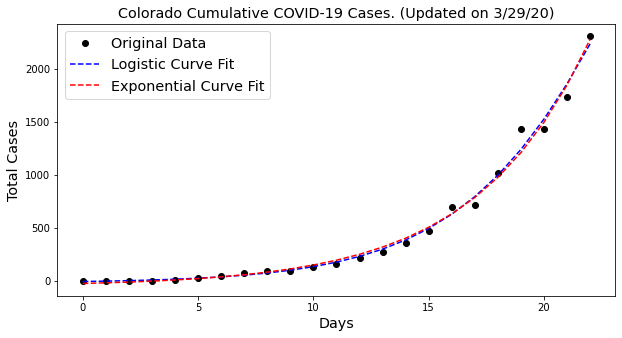



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 1993
	Confirmed cases on 3/21/20 	 194
	Ratio: 10.27
	Weekly increase: 927.3 %
	Daily increase: 39.5 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.9946597158232324
	Doubling Time (during middle of growth):  3.87 (± 0.9 ) days

** Based on Exponential Fit **

	R^2: 0.9912955710174126
	Doubling Time (represents overall growth):  2.98 (± 0.35 ) days


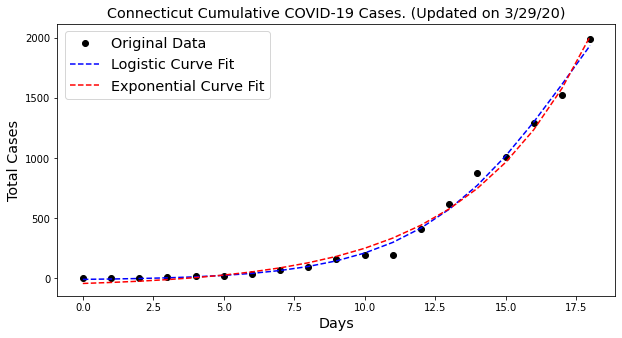



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 1720
	Confirmed cases on 3/21/20 	 304
	Ratio: 5.66
	Weekly increase: 465.8 %
	Daily increase: 28.1 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.9964453887862638
	Doubling Time (during middle of growth):  3.24 (± 0.43 ) days

** Based on Exponential Fit **

	R^2: 0.9800446791297543
	Doubling Time (represents overall growth):  3.6 (± 0.54 ) days


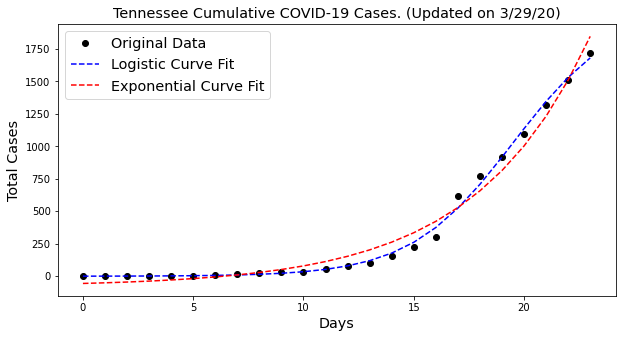



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 1653
	Confirmed cases on 3/21/20 	 247
	Ratio: 6.69
	Weekly increase: 569.2 %
	Daily increase: 31.2 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.9981580149412842
	Doubling Time (during middle of growth):  3.88 (± 0.52 ) days

** Based on Exponential Fit **

	R^2: 0.9936849825463716
	Doubling Time (represents overall growth):  3.16 (± 0.32 ) days


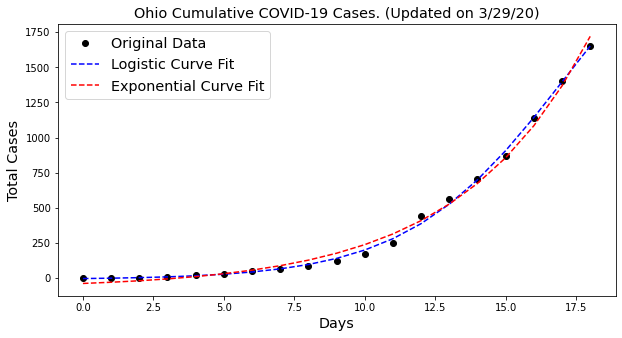



US state:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 1513
	Confirmed cases on 3/21/20 	 128
	Ratio: 11.82
	Weekly increase: 1082.0 %
	Daily increase: 42.3 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.9981496972791828
	Doubling Time (during middle of growth):  3.09 (± 0.34 ) days

** Based on Exponential Fit **

	R^2: 0.9927448894847682
	Doubling Time (represents overall growth):  2.4 (± 0.2 ) days


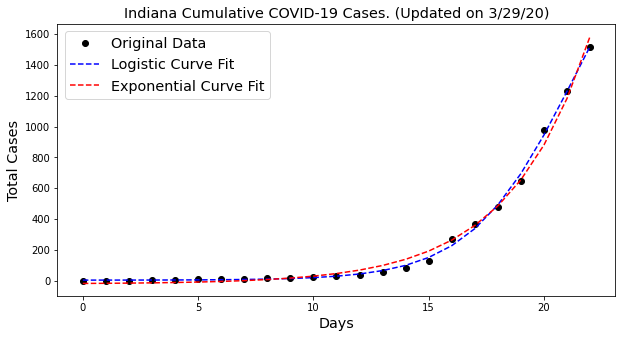



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 1239
	Confirmed cases on 3/21/20 	 193
	Ratio: 6.42
	Weekly increase: 542.0 %
	Daily increase: 30.4 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.9991949801889118
	Doubling Time (during middle of growth):  4.71 (± 0.42 ) days

** Based on Exponential Fit **

	R^2: 0.9987622482724922
	Doubling Time (represents overall growth):  2.72 (± 0.1 ) days


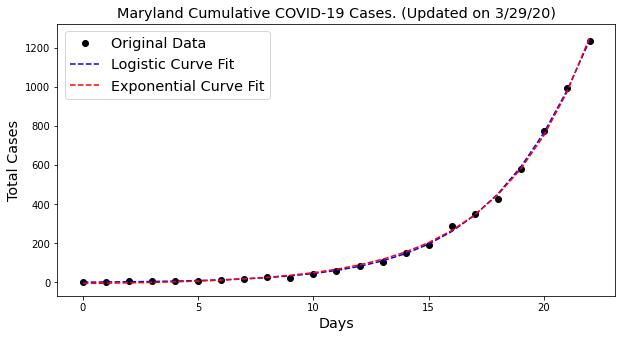



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 1191
	Confirmed cases on 3/21/20 	 256
	Ratio: 4.65
	Weekly increase: 365.2 %
	Daily increase: 24.6 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.9994134056713144
	Doubling Time (during middle of growth):  3.84 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.9903097583821234
	Doubling Time (represents overall growth):  3.48 (± 0.33 ) days


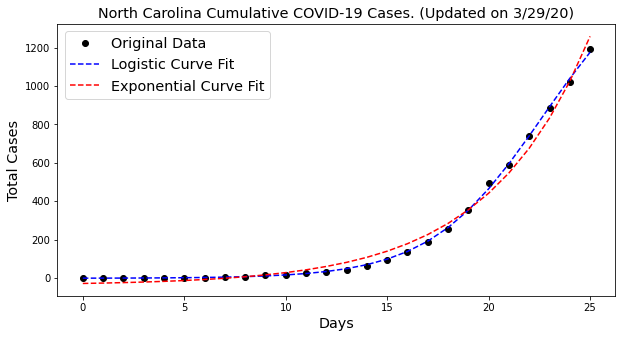



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 1164
	Confirmed cases on 3/21/20 	 282
	Ratio: 4.13
	Weekly increase: 312.8 %
	Daily increase: 22.4 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.9985162168417107
	Doubling Time (during middle of growth):  4.12 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.9910073758559675
	Doubling Time (represents overall growth):  4.12 (± 0.58 ) days


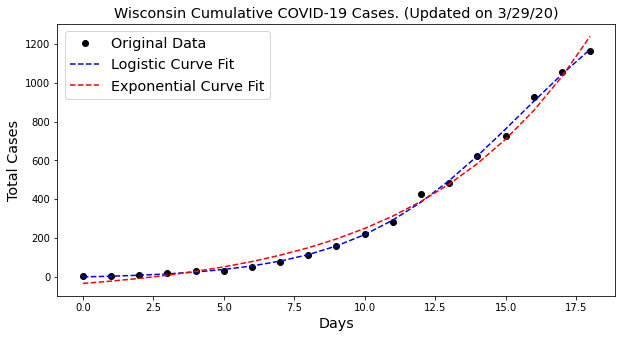



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 920
	Confirmed cases on 3/21/20 	 161
	Ratio: 5.71
	Weekly increase: 471.4 %
	Daily increase: 28.3 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.9926093463279256
	Doubling Time (during middle of growth):  5.83 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.9926093469910509
	Doubling Time (represents overall growth):  2.91 (± 0.25 ) days


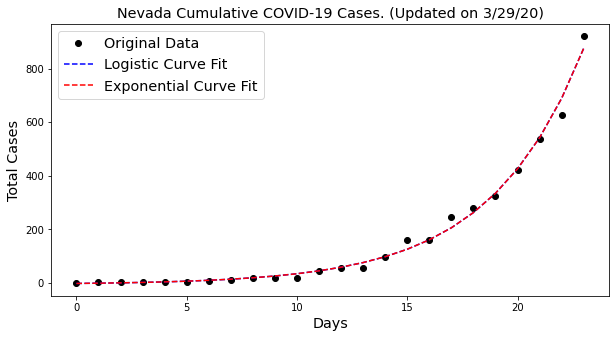



US state:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 919
	Confirmed cases on 3/21/20 	 104
	Ratio: 8.84
	Weekly increase: 783.7 %
	Daily increase: 36.5 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.9850681043536046
	Doubling Time (represents overall growth):  2.77 (± 0.18 ) days


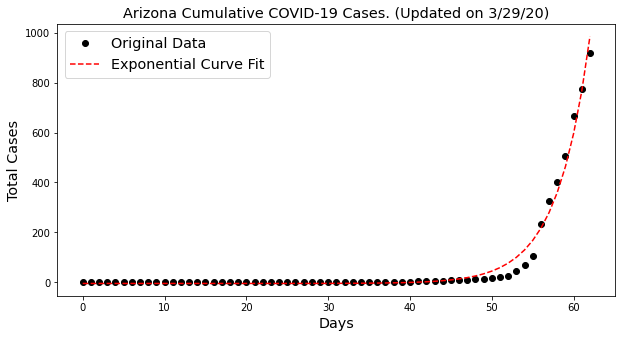



US state:  Missouri

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 915
	Confirmed cases on 3/21/20 	 81
	Ratio: 11.3
	Weekly increase: 1029.6 %
	Daily increase: 41.4 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.9986983440596472
	Doubling Time (during middle of growth):  2.59 (± 0.22 ) days

** Based on Exponential Fit **

	R^2: 0.9814799534064472
	Doubling Time (represents overall growth):  2.81 (± 0.42 ) days


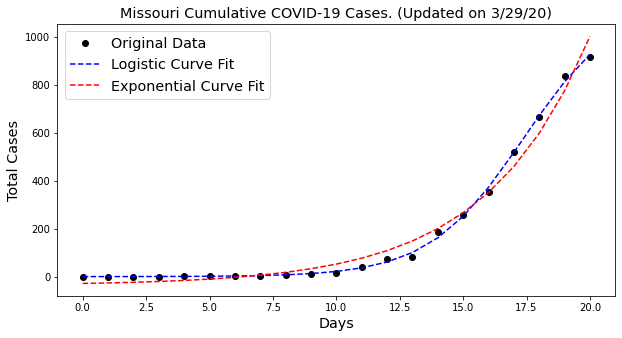



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 890
	Confirmed cases on 3/21/20 	 157
	Ratio: 5.67
	Weekly increase: 466.9 %
	Daily increase: 28.1 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.9985952741919271
	Doubling Time (during middle of growth):  4.78 (± 0.59 ) days

** Based on Exponential Fit **

	R^2: 0.9972175684012412
	Doubling Time (represents overall growth):  3.2 (± 0.19 ) days


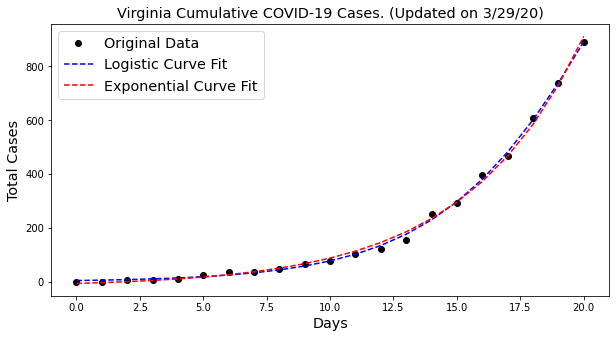



US state:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 825
	Confirmed cases on 3/21/20 	 131
	Ratio: 6.3
	Weekly increase: 529.8 %
	Daily increase: 30.1 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.9967914552550418
	Doubling Time (during middle of growth):  3.26 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.9888077598996313
	Doubling Time (represents overall growth):  3.54 (± 0.63 ) days


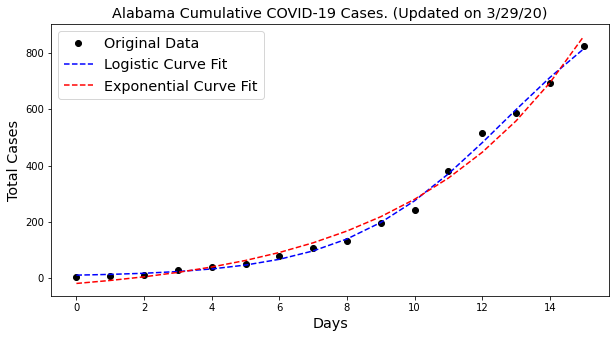



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 774
	Confirmed cases on 3/21/20 	 174
	Ratio: 4.45
	Weekly increase: 344.8 %
	Daily increase: 23.8 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.9910410403900826
	Doubling Time (during middle of growth):  4.43 (± 1.17 ) days

** Based on Exponential Fit **

	R^2: 0.9854442683504723
	Doubling Time (represents overall growth):  3.82 (± 0.55 ) days


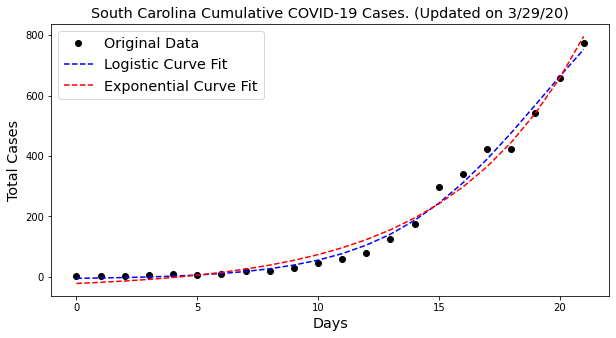



US state:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 759
	Confirmed cases on 3/21/20 	 140
	Ratio: 5.42
	Weekly increase: 442.1 %
	Daily increase: 27.3 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.9969451585376098
	Doubling Time (during middle of growth):  3.24 (± 0.53 ) days

** Based on Exponential Fit **

	R^2: 0.9834155364836823
	Doubling Time (represents overall growth):  4.06 (± 0.89 ) days


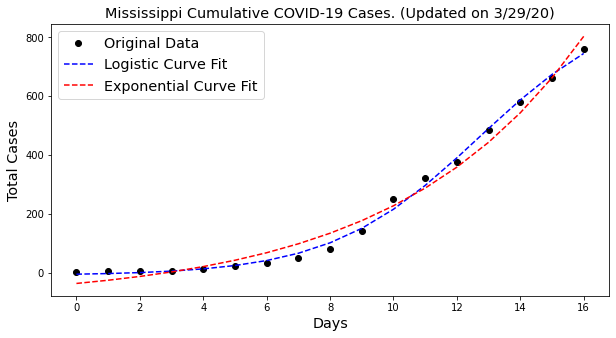



US state:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 720
	Confirmed cases on 3/21/20 	 118
	Ratio: 6.1
	Weekly increase: 510.2 %
	Daily increase: 29.5 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.9912243559716213
	Doubling Time (during middle of growth):  4.5 (± 1.22 ) days

** Based on Exponential Fit **

	R^2: 0.9875671276588242
	Doubling Time (represents overall growth):  3.47 (± 0.44 ) days


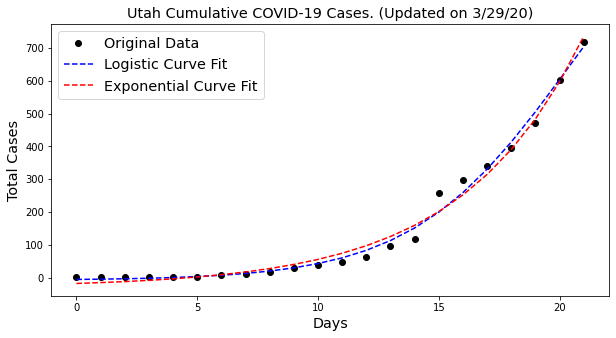



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 548
	Confirmed cases on 3/21/20 	 137
	Ratio: 4.0
	Weekly increase: 300.0 %
	Daily increase: 21.9 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.998045806334845
	Doubling Time (during middle of growth):  5.59 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.9966736738937034
	Doubling Time (represents overall growth):  3.62 (± 0.19 ) days


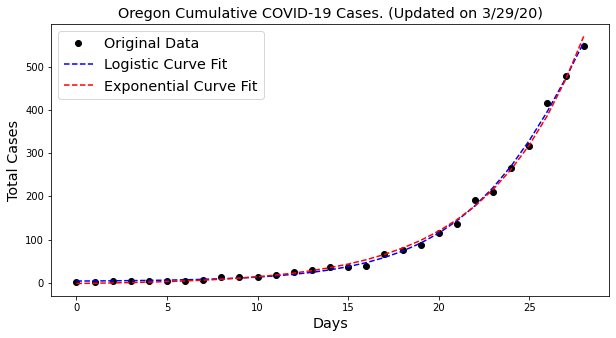



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 503
	Confirmed cases on 3/21/20 	 134
	Ratio: 3.75
	Weekly increase: 275.4 %
	Daily increase: 20.8 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9951417395982525
	Doubling Time (during middle of growth):  4.61 (± 0.84 ) days

** Based on Exponential Fit **

	R^2: 0.9870952603197896
	Doubling Time (represents overall growth):  4.68 (± 0.68 ) days


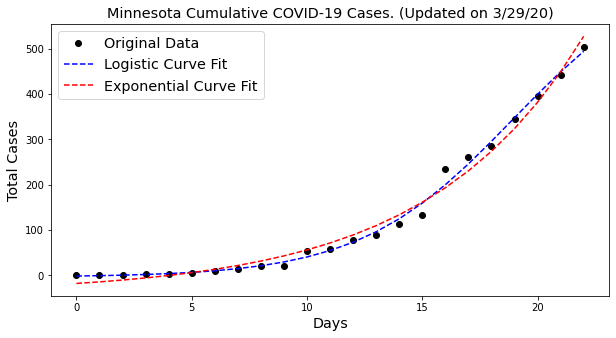



US state:  Kentucky

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 438
	Confirmed cases on 3/21/20 	 87
	Ratio: 5.03
	Weekly increase: 403.4 %
	Daily increase: 26.0 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.9981881258783265
	Doubling Time (during middle of growth):  4.21 (± 0.48 ) days

** Based on Exponential Fit **

	R^2: 0.9942173647479313
	Doubling Time (represents overall growth):  3.23 (± 0.26 ) days


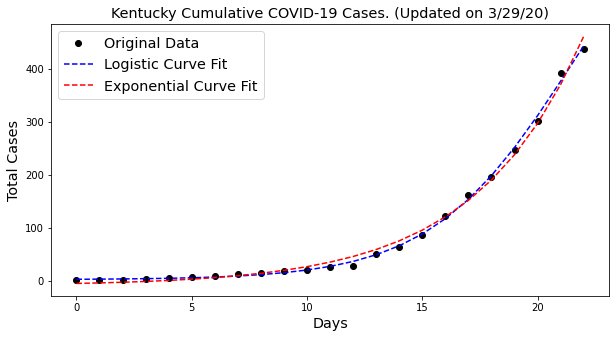



US state:  Oklahoma

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 429
	Confirmed cases on 3/21/20 	 53
	Ratio: 8.09
	Weekly increase: 709.4 %
	Daily increase: 34.8 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.9964753753364767
	Doubling Time (during middle of growth):  2.72 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.9836473184603096
	Doubling Time (represents overall growth):  2.84 (± 0.39 ) days


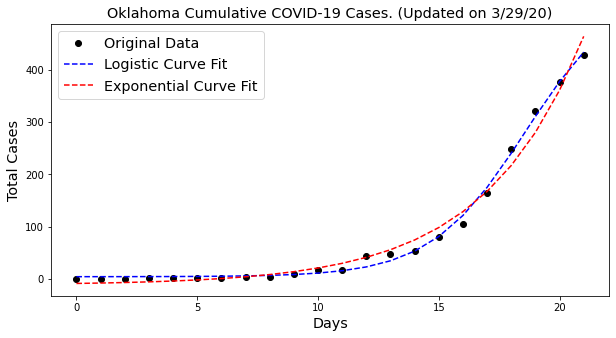



US state:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 426
	Confirmed cases on 3/21/20 	 122
	Ratio: 3.49
	Weekly increase: 249.2 %
	Daily increase: 19.6 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9942846544004003
	Doubling Time (during middle of growth):  2.86 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.9637415972573014
	Doubling Time (represents overall growth):  5.35 (± 2.38 ) days


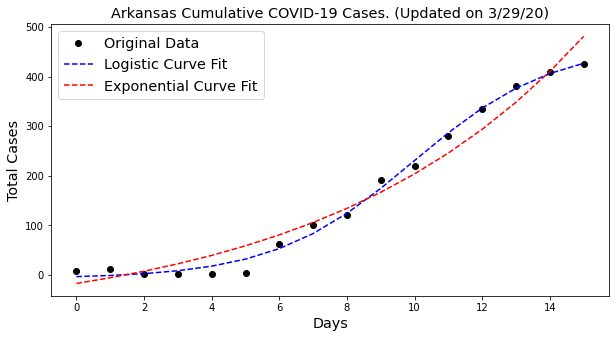



US state:  District of Columbia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 342
	Confirmed cases on 3/20/20 	 77
	Ratio: 4.44
	Weekly increase: 344.2 %
	Daily increase: 23.7 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.9968848473042264
	Doubling Time (during middle of growth):  3.79 (± 1.19 ) days

** Based on Exponential Fit **

	R^2: 0.9882346949528722
	Doubling Time (represents overall growth):  5.11 (± 1.88 ) days


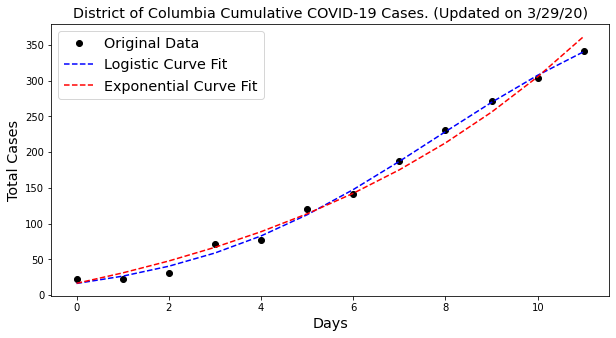



US state:  Iowa

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 336
	Confirmed cases on 3/21/20 	 69
	Ratio: 4.87
	Weekly increase: 387.0 %
	Daily increase: 25.4 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.99632170232588
	Doubling Time (during middle of growth):  4.46 (± 0.89 ) days

** Based on Exponential Fit **

	R^2: 0.9940322182445841
	Doubling Time (represents overall growth):  3.22 (± 0.3 ) days


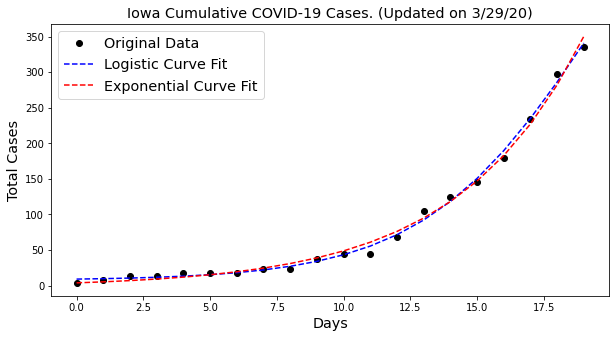



US state:  Kansas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 330
	Confirmed cases on 3/21/20 	 57
	Ratio: 5.79
	Weekly increase: 478.9 %
	Daily increase: 28.5 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.9991711820664785
	Doubling Time (during middle of growth):  5.07 (± 0.52 ) days

** Based on Exponential Fit **

	R^2: 0.9986283743439813
	Doubling Time (represents overall growth):  3.03 (± 0.13 ) days


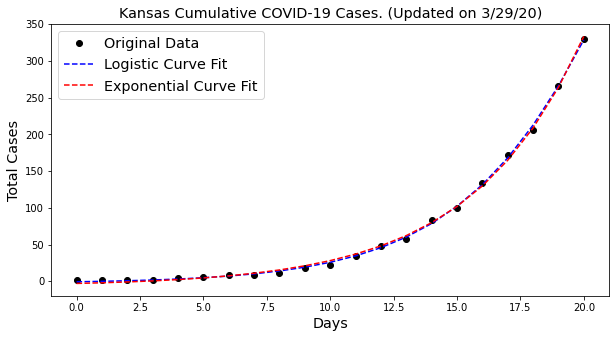



US state:  Rhode Island

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 294
	Confirmed cases on 3/21/20 	 66
	Ratio: 4.45
	Weekly increase: 345.5 %
	Daily increase: 23.8 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.9961609837046256
	Doubling Time (during middle of growth):  5.71 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.9951190669962301
	Doubling Time (represents overall growth):  3.57 (± 0.23 ) days


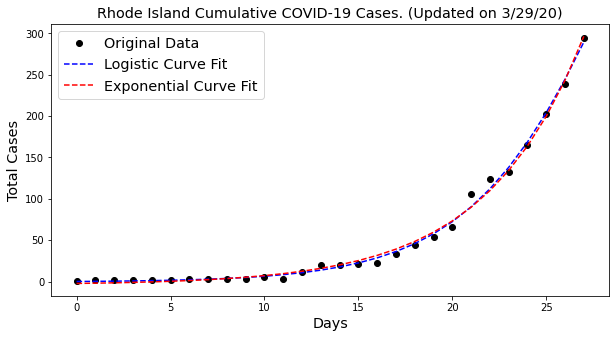



US state:  Idaho

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 281
	Confirmed cases on 3/21/20 	 42
	Ratio: 6.69
	Weekly increase: 569.0 %
	Daily increase: 31.2 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.993428018168732
	Doubling Time (during middle of growth):  3.65 (± 1.1 ) days

** Based on Exponential Fit **

	R^2: 0.9895903318016969
	Doubling Time (represents overall growth):  3.08 (± 0.48 ) days


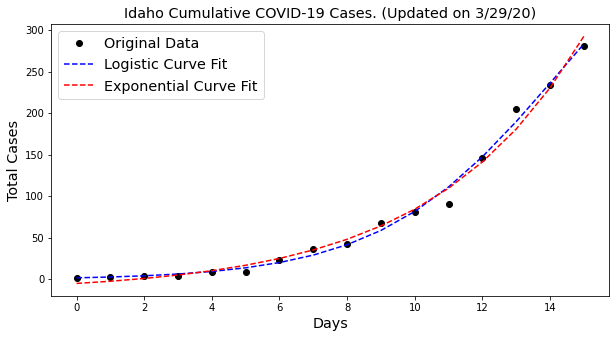



US state:  Maine

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 253
	Confirmed cases on 3/21/20 	 70
	Ratio: 3.61
	Weekly increase: 261.4 %
	Daily increase: 20.1 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.9914610525818016
	Doubling Time (during middle of growth):  9.02 (± 8.07 ) days

** Based on Exponential Fit **

	R^2: 0.9913522947296567
	Doubling Time (represents overall growth):  5.6 (± 1.12 ) days


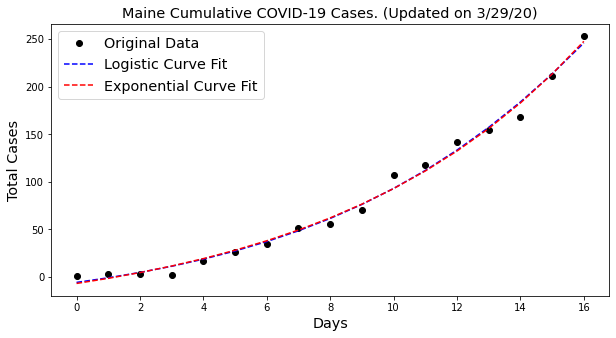



US state:  New Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 237
	Confirmed cases on 3/21/20 	 55
	Ratio: 4.31
	Weekly increase: 330.9 %
	Daily increase: 23.2 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.982795427130184
	Doubling Time (during middle of growth):  7.12 (± 3.62 ) days

** Based on Exponential Fit **

	R^2: 0.9827954279224937
	Doubling Time (represents overall growth):  3.56 (± 0.68 ) days


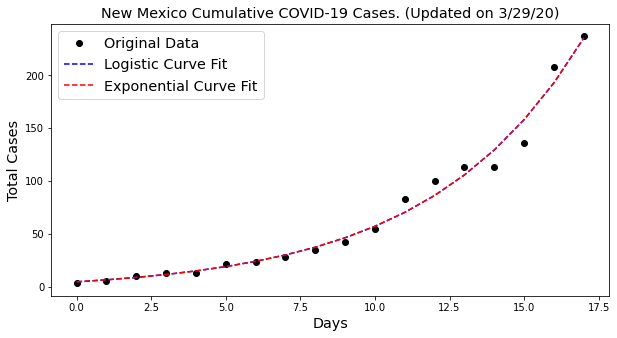



US state:  Vermont

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 235
	Confirmed cases on 3/21/20 	 49
	Ratio: 4.8
	Weekly increase: 379.6 %
	Daily increase: 25.1 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9991561107537387
	Doubling Time (during middle of growth):  3.11 (± 0.22 ) days

** Based on Exponential Fit **

	R^2: 0.9822747813457667
	Doubling Time (represents overall growth):  3.71 (± 0.61 ) days


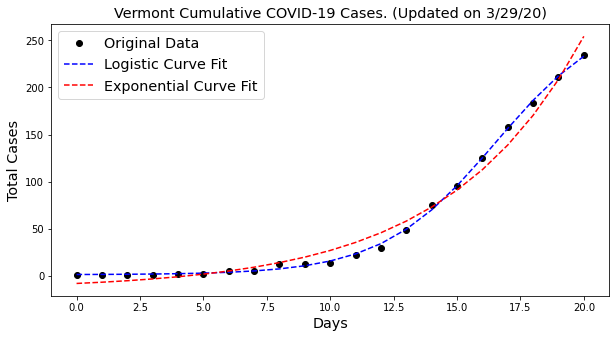



US state:  Delaware

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 232
	Confirmed cases on 3/21/20 	 45
	Ratio: 5.16
	Weekly increase: 415.6 %
	Daily increase: 26.4 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.9934417015431659
	Doubling Time (during middle of growth):  4.47 (± 1.31 ) days

** Based on Exponential Fit **

	R^2: 0.9896881512592589
	Doubling Time (represents overall growth):  3.84 (± 0.59 ) days


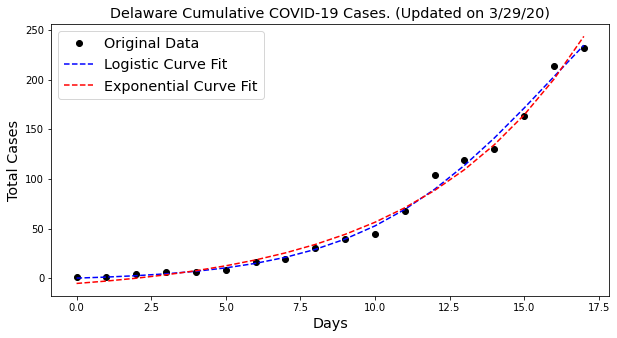



US state:  New Hampshire

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 214
	Confirmed cases on 3/21/20 	 61
	Ratio: 3.51
	Weekly increase: 250.8 %
	Daily increase: 19.6 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9929695388237344
	Doubling Time (during middle of growth):  5.41 (± 1.14 ) days

** Based on Exponential Fit **

	R^2: 0.9887699371787678
	Doubling Time (represents overall growth):  4.23 (± 0.45 ) days


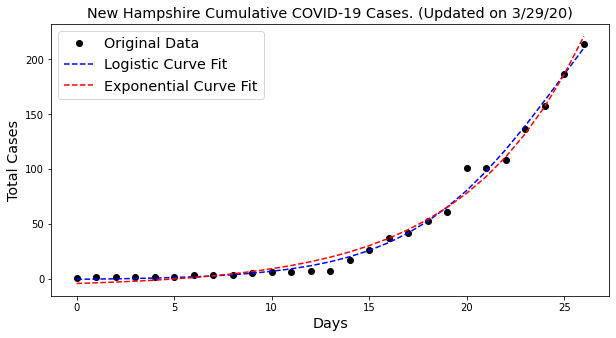



US state:  Montana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 154
	Confirmed cases on 3/21/20 	 27
	Ratio: 5.7
	Weekly increase: 470.4 %
	Daily increase: 28.2 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.9987581214243494
	Doubling Time (during middle of growth):  3.39 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.9922481961117704
	Doubling Time (represents overall growth):  3.33 (± 0.47 ) days


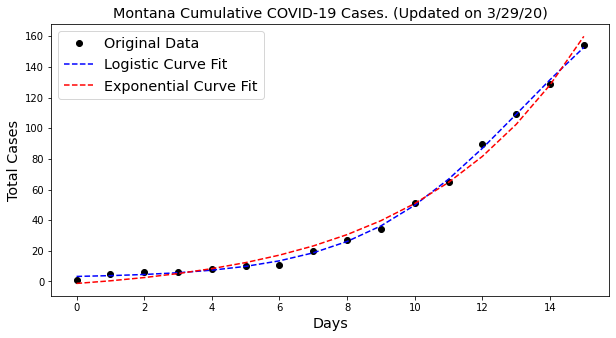



US state:  Hawaii

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 149
	Confirmed cases on 3/21/20 	 36
	Ratio: 4.14
	Weekly increase: 313.9 %
	Daily increase: 22.5 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.9820736294885072
	Doubling Time (during middle of growth):  4.03 (± 1.38 ) days

** Based on Exponential Fit **

	R^2: 0.9710315834709349
	Doubling Time (represents overall growth):  4.36 (± 0.97 ) days


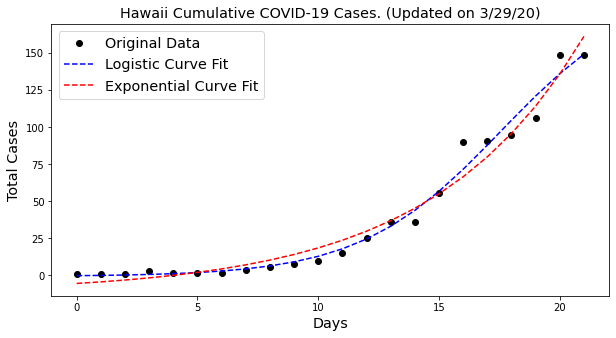



US state:  Puerto Rico

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 127
	Confirmed cases on 3/21/20 	 21
	Ratio: 6.05
	Weekly increase: 504.8 %
	Daily increase: 29.3 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.9966710392512856
	Doubling Time (during middle of growth):  5.48 (± 2.71 ) days

** Based on Exponential Fit **

	R^2: 0.9964769465894814
	Doubling Time (represents overall growth):  3.33 (± 0.42 ) days


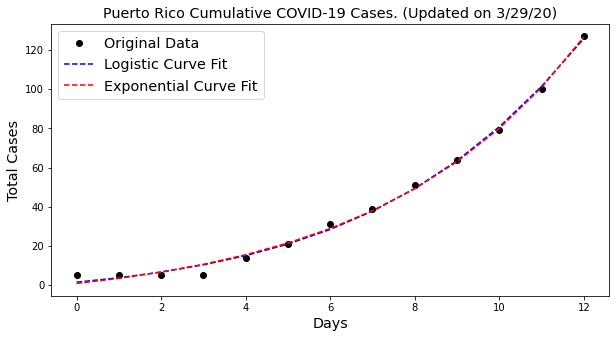



US state:  West Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 113
	Confirmed cases on 3/21/20 	 12
	Ratio: 9.42
	Weekly increase: 841.7 %
	Daily increase: 37.8 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.9978863993252626
	Doubling Time (during middle of growth):  2.59 (± 0.57 ) days

** Based on Exponential Fit **

	R^2: 0.9909562789047481
	Doubling Time (represents overall growth):  3.15 (± 0.78 ) days


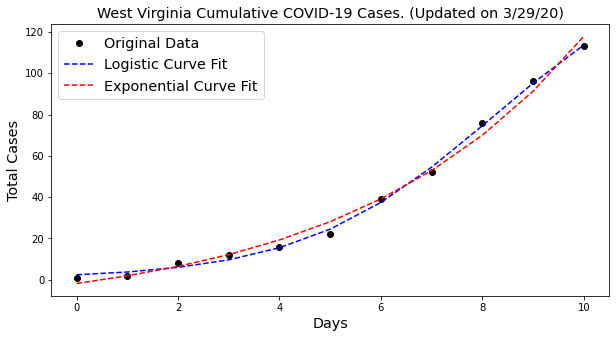



US state:  Nebraska

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 108
	Confirmed cases on 3/21/20 	 38
	Ratio: 2.84
	Weekly increase: 184.2 %
	Daily increase: 16.1 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9916831561069825
	Doubling Time (during middle of growth):  8.36 (± 3.51 ) days

** Based on Exponential Fit **

	R^2: 0.9909204203773451
	Doubling Time (represents overall growth):  6.12 (± 0.89 ) days


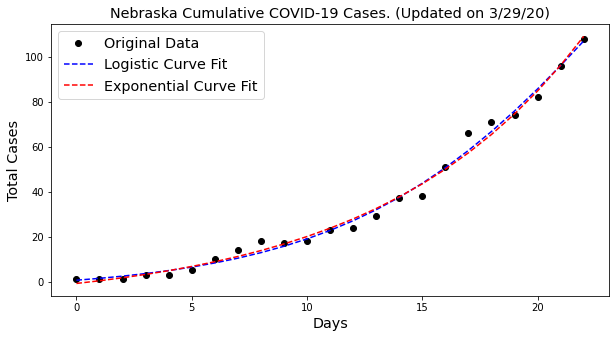



US state:  Grand Princess

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 103
	Confirmed cases on 3/21/20 	 23
	Ratio: 4.48
	Weekly increase: 347.8 %
	Daily increase: 23.9 % per day
	Doubling Time (represents recent growth): 3.2 days


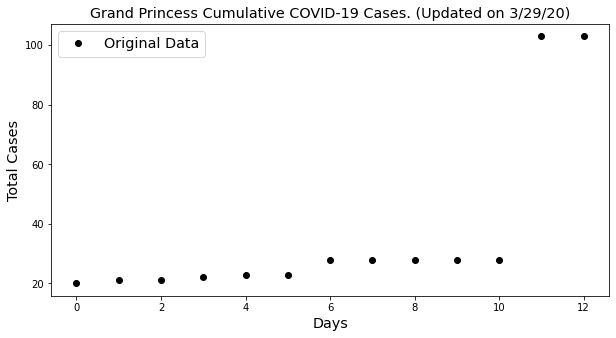



US state:  Alaska

** Based on Most Recent Week of Data **

	Confirmed cases on 3/29/20 	 102
	Confirmed cases on 3/21/20 	 13
	Ratio: 7.85
	Weekly increase: 684.6 %
	Daily increase: 34.2 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.9891301384801969
	Doubling Time (during middle of growth):  5.2 (± 2.91 ) days

** Based on Exponential Fit **

	R^2: 0.9886093812268799
	Doubling Time (represents overall growth):  3.27 (± 0.56 ) days


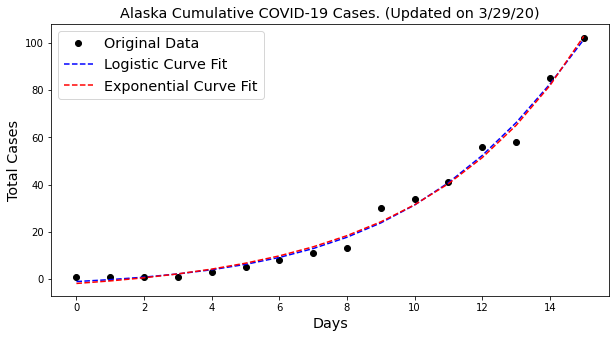

In [71]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    
    if state == "Recovered":
        continue
    
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


                  States  Inferred Doubling Time  95%CI  Recent Doubling Time
0               New York                     2.5    0.5                   1.8
1             New Jersey                     3.2    0.3                   2.1
2             California                     3.7    0.2                   3.4
3               Michigan                     3.4    0.6                   2.1
4          Massachusetts                     2.5    0.1                   2.2
5               Illinois                     2.9    0.1                   2.7
6             Washington                     4.9    0.2                   5.3
7                Florida                     3.9    0.5                   2.8
8              Louisiana                     3.6    0.4                   3.2
9           

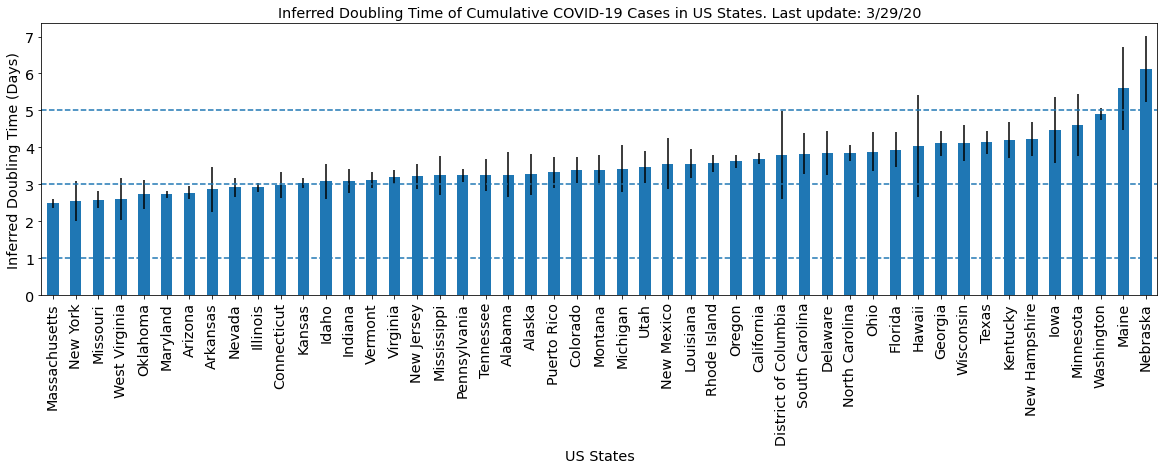

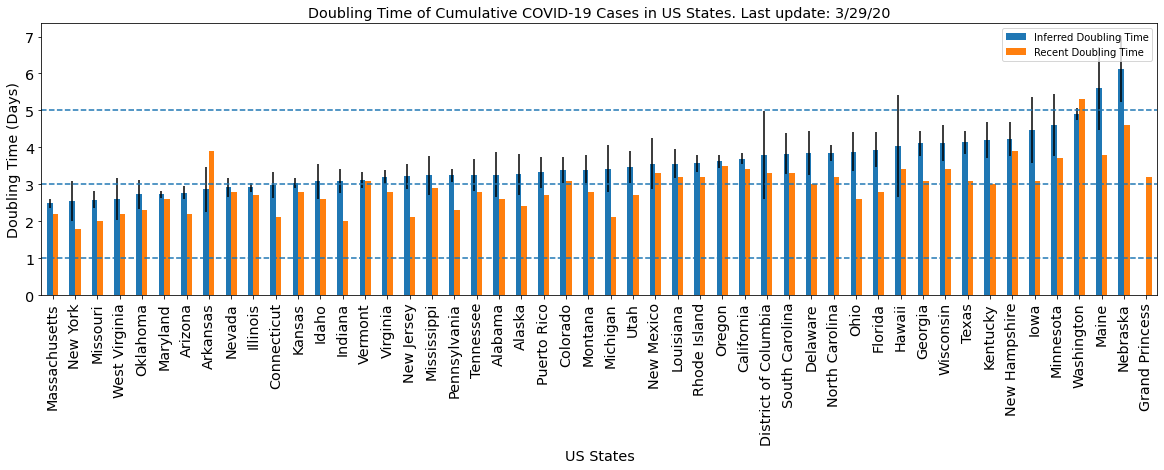

In [74]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).round(1))    

print('\n')
dt = pd.DataFrame(data = d).sort_values(by=['Inferred Doubling Time'])
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(20,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt.sort_values(by=['Inferred Doubling Time'])
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(20,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()